# Kuliah Di Depok V2 - Optimizing Information Theory: Fraud User Detection with Social Network Banking Data
----

The financial industry has been highly digitalized over the past several years. The addition of digital platforms in banking eases various operational processes. One of the most mainstream utilizations is the logging of loan applications by bank customers. Digital software can be used on the client side to apply for a loan and the bank can easily log all the details. Such details may include the information between the bank's customers.

In terms of loans, this issue is crucial as a study found that social networks play an important role in lending inside the banking industry [1]. Machine learning methods as heuristic solutions can optimize the detection process of fraud customers, trying to acquire lending by creating fake profiles. In terms of applying social networks, a dataset has been created as a benchmark for machine learning models in D-Graph [2]. This data set is useful for creating benchmarks between machine learning models, especially graphical neural network models. However, training a graph neural network requires a hefty amount of computing resources as on the feed-forward algorithm a graph of a social network is passed onto. Therefore, a lighter representation of the social network may need to be acquired and if possible, be implemented in a standard lighter machine learning algorithm compared to a graphical neural network. 


Given a bank with a dataset of its customers with their respective information alongside their loan activities, we were given the task of identifying whether a certain customer is a fraud. There are several sets of data, The first set is the Non-Borrowing, meaning the bank customers who did not apply for loans. Next is the Training and Testing set, which are the borrowing customers with the training set having labels indicating whether a customer with a certain unique ID is a fraud customer and the testing set serves the same purpose but with no label. **The label in the test set will be predicted in this work**. Lastly, we have the loan activities, a data set that provides information about relations between customers. A borrowing user would need to put in a reference contact (another customer of the bank) before applying, in which the loan type can vary and the user can apply for the loan at any time. 


In Figure 1, the exampled user from the train set is a fraud user. It is on the borrowing group and the loan activities set would enable a relationship between the borrowing user and the referenced user of the bank. On the other hand, the test set we are presented with still has unknown conditions for the user, therefore we will try to predict it. 

However, after performing an analysis of the given data set, the loan activities are in the form of an undirected graph. The stated USER_ID and REFERENCE_ID may not directly show which one is the borrower or the reference as some referenced users are in the train or test sets. 


## DEPEDENCIES
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.ensemble import IsolationForest
from collections import Counter
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, average_precision_score
from imblearn.over_sampling import BorderlineSMOTE,SMOTE
import math
import random
import joblib
import networkx as nx
from collections import defaultdict
import leidenalg as la
import igraph as ig
import gc
from sklearn.model_selection import train_test_split
import optuna
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA



## Feature Engineering - Extracting Graph Features
---

In [ ]:
df = pd.read_csv("loan_activities.csv")

### Node Features

---

Using given loan activities data that can be represented as directed graph of transactions, our team will extracting some graph features that will be analyzed further in the next step with some statistical approach. Those features are:
1. Page Rank
   
The page rank is mostly used in search engines, showing the most important pages. This method is used in this work to determine which users have high importance (e.g. how many nodes are connected) [3]. The NetworkX page rank functionalities that are used in this work would rank the nodes based on the structure of the incoming links. We would then be able to determine the importance of each node.

![PageRank](https://memgraph.com/images/blog/pagerank-algorithm-for-graph-databases/pagerank-algorithm-for-graph-databases%2Fmemgraph-pagerank-vin.png)

src = [MemGraph](https://memgraph.com/blog/pagerank-algorithm-for-graph-databases)

2. Degree Centrality
   
The degree in a graph is the number of edges connected to a node[4]. This information would be an extension to the page rank information as it discreetly shows how many nodes are connected to the node. 

3. In-Degree Centrality
   
The in-degree centrality for a node v is the fraction of nodes its incoming edges are connected to.

![In-Out-Degree](https://www.researchgate.net/profile/Sameer-Kumar-3/publication/272723743/figure/fig2/AS:294752151982083@1447285797440/Representation-of-in-degree-and-out-degree-of-a-node.png)

src = [Research Gate](https://www.researchgate.net/figure/Representation-of-in-degree-and-out-degree-of-a-node_fig2_272723743)

4. Out-Degree Centrality
   
The out-degree centrality for a node v is the fraction of nodes its outgoing edges are connected to.

5. Closeness Centrality
   
Closeness centrality [5] of a node u is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes.

$$C(u) = \frac{n-1}{\sum^{n-1}_{v=1}d(v,u)}$$

where d(v, u) is the shortest path distance between v and u, and n-1 is the number of nodes reachable from u. Notice that the closeness distance function computes the incoming distance to u for directed graphs. 

1. Hyperlink-Induced Topic Search (HITS)
HITS would provide information in two values for a node. **Authorities** estimate the node value based on the incoming links. **Hubs** estimates the node value based on outgoing links[6].

1. Local Clustering Coefficient
Given the customers as nodes have a network of other connected nodes, the local clustering coefficient would provide information about how connected that network is to the particular node.

1. Strongly Connected Component Sizes
A graph is said to be strongly connected if every pair of vertices(u, v) in the graph contains a path between each other. In an unweighted directed graph G, every pair of vertices u and v should have a path in each direction between them i.e., a bidirectional path. We want to find the size of the strongly connected graph.

1. Weakly Connected Component Sizes
Opposite to the strongly connected component sizes, the directed graph is weakly connected if there is a path between every two vertices in the underlying undirected graph (i.e, the graph formed when the direction of the edges is removed)

1.  Core Numbers
A k-core is a maximal subgraph that contains nodes of degree k or more (similar to the h-index in a sense). The core number of a node is the largest value k of a k-core containing that node.


In [ ]:
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['user_id'], row['reference_contact'], ts=row['ts'])



print("1. Computing Degree Centrality...")
degree_centrality = nx.degree_centrality(G)

print("2. Computing In-Degree Centrality...")
in_degree_centrality = nx.in_degree_centrality(G)

print("3. Computing Out-Degree Centrality...")
out_degree_centrality = nx.out_degree_centrality(G)

print("4. Computing Closeness Centrality...")
closeness_centrality = nx.closeness_centrality(G)

print("5. Computing PageRank...")
pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

print("6. Computing HITS...")
hubs, authorities = nx.hits(G, max_iter=100)

print("7. Computing Local Clustering Coefficient...")
clustering = nx.clustering(G)

print("8. Computing Strongly Connected Component Sizes...")
scc = nx.strongly_connected_components(G)
scc_sizes = {node: len(c) for c in scc for node in c}

print("9. Computing Weakly Connected Component Sizes...")
wcc = nx.weakly_connected_components(G)
wcc_sizes = {node: len(c) for c in wcc for node in c}

print("10. Computing Core Numbers...")
core_numbers = nx.core_number(G)

print("Creating results DataFrame...")
results = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[n] for n in G.nodes()],
    'In-Degree Centrality': [in_degree_centrality[n] for n in G.nodes()],
    'Out-Degree Centrality': [out_degree_centrality[n] for n in G.nodes()],
    'Closeness Centrality': [closeness_centrality[n] for n in G.nodes()],
    'PageRank': [pagerank[n] for n in G.nodes()],
    'Hub Score': [hubs[n] for n in G.nodes()],
    'Authority Score': [authorities[n] for n in G.nodes()],
    'Local Clustering Coefficient': [clustering[n] for n in G.nodes()],
    'SCC Size': [scc_sizes[n] for n in G.nodes()],
    'WCC Size': [wcc_sizes[n] for n in G.nodes()],
    'Core Number': [core_numbers[n] for n in G.nodes()],
})
results.to_csv('node_data_fin.csv',index=False)
results

#### Graph Community Features

---

We would also like to add several other features regarding the graph in the form of Community Features. These features have been tested in social network data and proved to be having positive effects [7]. The users are assigned to a certain community, a clustering method for a graph to enable extraction of additional information. 

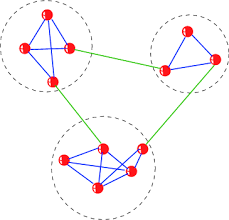

src = [Springer](https://link.springer.com/referenceworkentry/10.1007/978-1-4614-1800-9_33)

1. Assigning Communities

![Leiden Alg](https://www.researchgate.net/publication/332023058/figure/fig6/AS:959327875657742@1605732997902/Leiden-algorithm-The-Leiden-algorithm-starts-from-a-singleton-partition-a-The.png)

src = [Research Gate](https://www.researchgate.net/figure/Leiden-algorithm-The-Leiden-algorithm-starts-from-a-singleton-partition-a-The_fig6_332023058)

We would find the communities using Leiden’s algorithm [8]. This method is a hierarchical clustering method that utilizes a recursive method of moving nodes, refining the clusters, and aggregating them to form communities.

1. Determining Community sizes
   
We can then determine the size of each community using the previously produced community assigned to each data point.


In [ ]:
ig_graph = ig.Graph.from_networkx(G)
partition = la.find_partition(ig_graph, la.ModularityVertexPartition)


community_dict = {node: membership for node, membership in enumerate(partition.membership)}
user_to_node = {user: i for i, user in enumerate(G.nodes())}
node_to_user = {i: user for user, i in user_to_node.items()}


user_community_dict = {node_to_user[node]: community for node, community in community_dict.items()}
df['community'] = df['user_id'].map(user_community_dict)
community_sizes = df['community'].value_counts()
df['community_size'] = df['community'].map(community_sizes)


hub_scores, authority_scores = nx.hits(G)
df['hub_score'] = df['user_id'].map(hub_scores).fillna(0)
df['authority_score'] = df['user_id'].map(authority_scores).fillna(0)


print(df[['user_id', 'reference_contact', 'loan_type', 'community']])


num_communities = len(set(community_dict.values()))
print(f"\nNumber of communities detected: {num_communities}")

print("\nCommunity size statistics:")
print(df['community_size'].describe())



modularity = partition.quality()
print(f"\nModularity of the partition: {modularity}")


print("\nDirected Graph Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is the graph strongly connected? {nx.is_strongly_connected(G)}")
print(f"Number of strongly connected components: {nx.number_strongly_connected_components(G)}")
print(f"Is the graph weakly connected? {nx.is_weakly_connected(G)}")
print(f"Number of weakly connected components: {nx.number_weakly_connected_components(G)}")


top_hubs = df.nlargest(5, 'hub_score')
top_authorities = df.nlargest(5, 'authority_score')

print("\nTop 5 Hubs (users who refer many others):")
print(top_hubs[['user_id', 'hub_score']])

print("\nTop 5 Authorities (users who are referred by many others):")
print(top_authorities[['user_id', 'authority_score']])
df.to_csv("auth_fin.csv",index=False)
df

## DATA PRE-PROCESSING 
---

First, our team will be preparing the four datasets:
Non-Borrowing
Loan Activities
Train Set
Test Set


We will work around the loan activities set as it shows relations or connections between the borrowing user ID and the reference contact ID with extracted graph features such as the information of each user and the reference alongside the information of the community  would be beneficial in determining the authenticity of the customers. Besides from previous step we also set the type of borrowing user as type 1 and non-borrowing as 0.

In [1]:
au = pd.read_csv('auth_fin.csv')
nd = pd.read_csv('node_data_fin.csv')
nb = pd.read_csv('non_borrower_user.csv')
te = pd.read_csv('test.csv')
tr = pd.read_csv('train.csv')

nb['type'] = 0
tr['type'] = 1
te['type'] = 1

nd_drop = nd.drop_duplicates(subset=['Node'])
feat = pd.concat([tr,te,nb], axis=0).sort_values(by='user_id')

In [2]:
print(nb.shape)
print(te.shape)
print(tr.shape)
print(au.shape)
print(nd.shape)

(2474949, 19)
(367702, 19)
(857899, 20)
(4300999, 8)
(3700550, 12)


Our team finds that there is samples of test user_id that dont exist as a user_id in loan activities but all of those samples are existed as reference_id. Knowing this problem , our team transform the directed graph of loan activities to become undirected with placeholder feature **is loaned** where 1 is the reversed graph dan 0 is for the original data.

In [ ]:
sample = te[~te.user_id.isin(au.user_id.values)]
print(f"Non exist test sample as user_id : {len(sample)}")
print(f"Non exist test sample as user_id and not exist as reference_id : {len(sample[~sample.user_id.isin(au.reference_contact.values)])}")

In [3]:
new_user_ids = au.reference_contact.drop_duplicates().values
new_entries = pd.DataFrame({'user_id': new_user_ids})
new_entries = new_entries.merge(au,left_on='user_id',right_on='reference_contact', suffixes=('', '_reference'),how='left')
new_entries.drop(columns='reference_contact',inplace=True)
new_entries.rename(columns={'user_id_reference':'reference_contact'},inplace=True)
new_entries['is_loaned'] = 1
new_entries.sort_values(by='user_id')

user_id  reference_contact  loan_type   ts  community  \
3248112        0             304449          5  440        222   
1704148        2            3473066          4  142        687   
1580693        3            3522095          4  516        348   
1813101        4            2977599          4  452        447   
133437         5             261660          1  116       1556   
...          ...                ...        ...  ...        ...   
1443735  3700546            1854313          4  668       1678   
1443736  3700546            2059738          6  665       1678   
240465   3700548            1360566          1  314        365   
2972057  3700549            1616566          8  789       1581   
2972056  3700549            2189451          5  751       1581   

         community_size     hub_score  authority_score  is_loaned  
3248112            2802  2.575203e-23     0.000000e+00          1  
1704148            2214  2.212757e-22     3.647619e-21          1  
1580693            2448 -1.616042e-22     0.000000e+00          1  
1813101            2313 -5.731067e-22     0.000000e+00          1  
133437             1888  5.265821e-24     0.000000e+00          1  
...                 ...           ...              ...        ...  
1443735            1695  4.381322e-23     0.000000e+00          1  
1443736            1695  3.010779e-22     6.772504e-20          1  
240465             2432 -7.038152e-23     1.741378e-21          1  
2972057            1857 -1.318186e-22     8.495224e-20          1  
2972056            1857 -5.635477e-23    -1.828654e-20          1  

[4300999 rows x 9 columns]

In [4]:
au['is_loaned'] = 0
auc = pd.concat([au,new_entries],ignore_index=True)
auc.sort_values('user_id')

user_id  reference_contact  loan_type   ts  community  \
7549111        0             304449          5  440        222   
376776         1            2592936          2  423        648   
6005147        2            3473066          4  142        687   
5881692        3            3522095          4  516        348   
6114100        4            2977599          4  452        447   
...          ...                ...        ...  ...        ...   
1547768  3700547            1334850          5  505        959   
162984   3700548            1360566          1   61        365   
4541464  3700548            1360566          1  314        365   
7273056  3700549            1616566          8  789       1581   
7273055  3700549            2189451          5  751       1581   

         community_size     hub_score  authority_score  is_loaned  
7549111            2802  2.575203e-23     0.000000e+00          1  
376776             2241  3.732690e-23     0.000000e+00          0  
6005147            2214  2.212757e-22     3.647619e-21          1  
5881692            2448 -1.616042e-22     0.000000e+00          1  
6114100            2313 -5.731067e-22     0.000000e+00          1  
...                 ...           ...              ...        ...  
1547768            2125  3.539861e-24     0.000000e+00          0  
162984             2432  3.314114e-24    -1.232716e-20          0  
4541464            2432 -7.038152e-23     1.741378e-21          1  
7273056            1857 -1.318186e-22     8.495224e-20          1  
7273055            1857 -5.635477e-23    -1.828654e-20          1  

[8601998 rows x 9 columns]

The undirected graph then joined with each features for the all user on user_id and reference_contact and also the community feature of the loaner of the transaction record.

In [5]:
merged_df = auc.merge(nd_drop, left_on='user_id',right_on='Node')
merged_df.drop('Node',inplace=True,axis=1)
merged_df = merged_df.merge(feat, on='user_id',suffixes=('', '_user'))
merged_df.sort_values('user_id')

user_id  reference_contact  loan_type   ts  community  \
7549111        0             304449          5  440        222   
376776         1            2592936          2  423        648   
6005147        2            3473066          4  142        687   
5881692        3            3522095          4  516        348   
6114100        4            2977599          4  452        447   
...          ...                ...        ...  ...        ...   
1547768  3700547            1334850          5  505        959   
162984   3700548            1360566          1   61        365   
4541464  3700548            1360566          1  314        365   
7273056  3700549            1616566          8  789       1581   
7273055  3700549            2189451          5  751       1581   

         community_size     hub_score  authority_score  is_loaned  \
7549111            2802  2.575203e-23     0.000000e+00          1   
376776             2241  3.732690e-23     0.000000e+00          0   
6005147            2214  2.212757e-22     3.647619e-21          1   
5881692            2448 -1.616042e-22     0.000000e+00          1   
6114100            2313 -5.731067e-22     0.000000e+00          1   
...                 ...           ...              ...        ...   
1547768            2125  3.539861e-24     0.000000e+00          0   
162984             2432  3.314114e-24    -1.232716e-20          0   
4541464            2432 -7.038152e-23     1.741378e-21          1   
7273056            1857 -1.318186e-22     8.495224e-20          1   
7273055            1857 -5.635477e-23    -1.828654e-20          1   

         Degree Centrality  ...       pc9  pc10      pc11      pc12      pc13  \
7549111       2.702302e-07  ... -1.000000   0.0 -1.000000 -1.000000 -1.000000   
376776        2.702302e-07  ...  0.993908   1.0  0.103175  0.006092  0.053097   
6005147       2.702302e-07  ... -1.000000   0.0 -1.000000 -1.000000 -1.000000   
5881692       2.702302e-07  ...  0.976923   1.0  0.072727  0.023077  0.078431   
6114100       2.702302e-07  ... -1.000000   0.0 -1.000000 -1.000000 -1.000000   
...                    ...  ...       ...   ...       ...       ...       ...   
1547768       5.404603e-07  ... -1.000000   0.0 -1.000000 -1.000000 -1.000000   
162984        5.404603e-07  ... -1.000000   0.0 -1.000000 -1.000000 -1.000000   
4541464       5.404603e-07  ... -1.000000   0.0 -1.000000 -1.000000 -1.000000   
7273056       5.404603e-07  ... -1.000000   0.0 -1.000000 -1.000000 -1.000000   
7273055       5.404603e-07  ... -1.000000   0.0 -1.000000 -1.000000 -1.000000   

         pc14      pc15      pc16  label  type  
7549111 -1.00 -1.000000 -1.000000    NaN     0  
376776   1.00  0.007937  0.166667    NaN     0  
6005147 -1.00 -1.000000 -1.000000    NaN     0  
5881692  0.75  0.018182  0.250000    0.0     1  
6114100 -1.00 -1.000000 -1.000000    NaN     1  
...       ...       ...       ...    ...   ...  
1547768 -1.00 -1.000000 -1.000000    NaN     0  
162984  -1.00 -1.000000 -1.000000    0.0     1  
4541464 -1.00 -1.000000 -1.000000    0.0     1  
7273056 -1.00 -1.000000 -1.000000    NaN     0  
7273055 -1.00 -1.000000 -1.000000    NaN     0  

[8601998 rows x 39 columns]

In [6]:
merged_df = merged_df.merge(feat.drop(columns=['label']), left_on='reference_contact',right_on='user_id', suffixes=('', '_reference'),how='left')
merged_df.sort_values('user_id')

user_id  reference_contact  loan_type   ts  community  \
7549111        0             304449          5  440        222   
376776         1            2592936          2  423        648   
6005147        2            3473066          4  142        687   
5881692        3            3522095          4  516        348   
6114100        4            2977599          4  452        447   
...          ...                ...        ...  ...        ...   
1547768  3700547            1334850          5  505        959   
162984   3700548            1360566          1   61        365   
4541464  3700548            1360566          1  314        365   
7273056  3700549            1616566          8  789       1581   
7273055  3700549            2189451          5  751       1581   

         community_size     hub_score  authority_score  is_loaned  \
7549111            2802  2.575203e-23     0.000000e+00          1   
376776             2241  3.732690e-23     0.000000e+00          0   
6005147            2214  2.212757e-22     3.647619e-21          1   
5881692            2448 -1.616042e-22     0.000000e+00          1   
6114100            2313 -5.731067e-22     0.000000e+00          1   
...                 ...           ...              ...        ...   
1547768            2125  3.539861e-24     0.000000e+00          0   
162984             2432  3.314114e-24    -1.232716e-20          0   
4541464            2432 -7.038152e-23     1.741378e-21          1   
7273056            1857 -1.318186e-22     8.495224e-20          1   
7273055            1857 -5.635477e-23    -1.828654e-20          1   

         Degree Centrality  ...  pc8_reference  pc9_reference  pc10_reference  \
7549111       2.702302e-07  ...          0.106       0.963636             1.0   
376776        2.702302e-07  ...          1.210       0.985342             5.0   
6005147       2.702302e-07  ...          0.094       1.000000             0.0   
5881692       2.702302e-07  ...          0.148       0.783069             0.0   
6114100       2.702302e-07  ...          0.725       1.000000             1.0   
...                    ...  ...            ...            ...             ...   
1547768       5.404603e-07  ...         -1.000      -1.000000             0.0   
162984        5.404603e-07  ...         -1.000      -1.000000             0.0   
4541464       5.404603e-07  ...         -1.000      -1.000000             0.0   
7273056       5.404603e-07  ...         -1.000      -1.000000             0.0   
7273055       5.404603e-07  ...         -1.000      -1.000000             0.0   

         pc11_reference  pc12_reference  pc13_reference  pc14_reference  \
7549111        0.108108        0.036364        0.030303        1.000000   
376776         0.087379        0.014658        0.047872        0.777778   
6005147       -1.000000       -1.000000        0.074074        0.500000   
5881692        0.365854        0.216931        0.057692        1.000000   
6114100       -1.000000       -1.000000        0.086957        0.750000   
...                 ...             ...             ...             ...   
1547768       -1.000000       -1.000000       -1.000000       -1.000000   
162984        -1.000000       -1.000000       -1.000000       -1.000000   
4541464       -1.000000       -1.000000       -1.000000       -1.000000   
7273056       -1.000000       -1.000000       -1.000000       -1.000000   
7273055       -1.000000       -1.000000       -1.000000       -1.000000   

         pc15_reference  pc16_reference  type_reference  
7549111        0.027027        1.000000               1  
376776         0.024272        0.555556               1  
6005147       -1.000000       -1.000000               1  
5881692       -1.000000       -1.000000               0  
6114100        0.010870        0.125000               1  
...                 ...             ...             ...  
1547768       -1.000000       -1.000000               0  
162984        -1.000000       -1.000000          

In [7]:
label_col = merged_df.pop('label')
merged_df['label'] = label_col

merged_df

user_id  reference_contact  loan_type   ts  community  \
0        2223129             903716          1  671       1303   
1        1380939             484583          1   89          2   
2        2724411            1185034          1  230        942   
3        2401751            1369254          1  120        932   
4        1982168              21797          1   57         16   
...          ...                ...        ...  ...        ...   
8601993  1113794            3456577         11  361       1654   
8601994  1942605             823962         11   27       1210   
8601995  2014662            2194264         11  198       1518   
8601996  1657495            2844279         11  609        957   
8601997  2316823            1071963         11    1        913   

         community_size     hub_score  authority_score  is_loaned  \
0                  2072 -6.677590e-23     0.000000e+00          0   
1                 18775 -4.509115e-25     5.326763e-20          0   
2                  2154 -1.790961e-23     1.256463e-20          0   
3                  2136 -2.387055e-24     9.492535e-21          0   
4                  8326 -7.566424e-23    -2.631246e-20          0   
...                 ...           ...              ...        ...   
8601993            1777 -4.260586e-23    -7.179171e-20          1   
8601994            2006 -1.224052e-22     0.000000e+00          1   
8601995            1945 -2.102026e-22     0.000000e+00          1   
8601996            2123  2.793758e-20     0.000000e+00          1   
8601997            2144 -5.246509e-23    -2.698224e-20          1   

         Degree Centrality  ...  pc9_reference  pc10_reference  \
0             1.080921e-06  ...      -1.000000             0.0   
1             8.106905e-07  ...       0.991663             2.0   
2             1.080921e-06  ...      -1.000000             0.0   
3             5.404603e-07  ...       0.968750             0.0   
4             1.080921e-06  ...      -1.000000             0.0   
...                    ...  ...            ...             ...   
8601993       2.702302e-07  ...       0.969456             6.0   
8601994       5.404603e-07  ...      -1.000000             0.0   
8601995       2.702302e-07  ...      -1.000000             0.0   
8601996       2.702302e-07  ...       0.965789             0.0   
8601997       2.702302e-07  ...       0.999296             1.0   

         pc11_reference  pc12_reference  pc13_reference  pc14_reference  \
0             -1.000000       -1.000000       -1.000000       -1.000000   
1              0.027875        0.008337        0.057348        0.687500   
2             -1.000000       -1.000000       -1.000000       -1.000000   
3              0.111111        0.031250        0.250000        1.000000   
4             -1.000000       -1.000000       -1.000000       -1.000000   
...                 ...             ...             ...             ...   
8601993        0.049211        0.030544        0.046875        0.916667   
8601994       -1.000000       -1.000000       -1.000000       -1.000000   
8601995       -1.000000       -1.000000       -1.000000       -1.000000   
8601996        0.067227        0.034211        0.099099        0.545455   
8601997        0.006579        0.000704        0.066225        0.800000   

         pc15_reference  pc16_reference  type_reference  label  
0             -1.000000          -1.000               0    NaN  
1              0.006969           0.125               1    NaN  
2             -1.000000          -1.000               0    NaN  
3             -1.000000          -1.000               1    NaN  
4             -1.000000          -1.000               0    0.0  
...                 ...             ...             ...    ...  
8601993        0.005571           0.125               1    NaN  
8601994       -1.000000          -1.000               1    0.0  
8601995       -1.000000          -1.000               1    NaN  
8601996       -1.000000          -1.000    

In [8]:
merged_df.isnull().sum()

user_id                               0
reference_contact                     0
loan_type                             0
ts                                    0
community                             0
community_size                        0
hub_score                             0
authority_score                       0
is_loaned                             0
Degree Centrality                     0
In-Degree Centrality                  0
Out-Degree Centrality                 0
Closeness Centrality                  0
PageRank                              0
Hub Score                             0
Authority Score                       0
Local Clustering Coefficient          0
SCC Size                              0
WCC Size                              0
Core Number                           0
pc0                                   0
pc1                                   0
pc2                                   0
pc3                                   0
pc4                                   0


In [9]:
nb_split = merged_df[merged_df['type'] == 0]
train_split = merged_df[(merged_df['type'] == 1) & (merged_df['label'].notnull())]
test_split = merged_df[(merged_df['type'] == 1) & (merged_df['label'].isnull())]

# Drop the 'type' column if not needed
nb_split = nb_split.drop(columns=['type'])
train_split = train_split.drop(columns=['type'])
test_split = test_split.drop(columns=['type'])

print(train_split.shape)
print(test_split.shape)
print(nb_split.shape)

(2468622, 57)
(1059870, 57)
(5073506, 57)


In [10]:
pd.set_option('display.max_columns', None)
train_split.head()

user_id  reference_contact  loan_type   ts  community  community_size  \
4   1982168              21797          1   57         16            8326   
12  2165537            3012160          1  264        198            2924   
13  3037956            1833243          1  181        389            2391   
15  2827506             495272          1  406         98            3767   
16  2592972            2001227          1  710        358            2442   

       hub_score  authority_score  is_loaned  Degree Centrality  \
4  -7.566424e-23    -2.631246e-20          0       1.080921e-06   
12 -6.566500e-22     0.000000e+00          0       1.621381e-06   
13 -2.426323e-22    -4.318253e-21          0       1.080921e-06   
15  2.053722e-22     0.000000e+00          0       1.080921e-06   
16  1.024558e-22     0.000000e+00          0       2.702302e-07   

    In-Degree Centrality  Out-Degree Centrality  Closeness Centrality  \
4           2.702302e-07           8.106905e-07          4.804092e-07   
12          0.000000e+00           1.621381e-06          0.000000e+00   
13          2.702302e-07           8.106905e-07          2.702302e-07   
15          0.000000e+00           1.080921e-06          0.000000e+00   
16          0.000000e+00           2.702302e-07          0.000000e+00   

        PageRank     Hub Score  Authority Score  Local Clustering Coefficient  \
4   1.801934e-07  3.750437e-22    -1.015373e-19                      0.000000   
12  1.342543e-07  1.533043e-21    -0.000000e+00                      0.066667   
13  3.639498e-07 -2.623100e-22    -2.247078e-21                      0.000000   
15  1.342543e-07  4.280865e-22    -0.000000e+00                      0.000000   
16  1.342543e-07  6.272916e-23    -0.000000e+00                      0.000000   

    SCC Size  WCC Size  Core Number  pc0  pc1    pc2    pc3       pc4  pc5  \
4          1   3700550            2  1.0  3.0  2.760  2.170  0.786232  1.9   
12         1   3700550            3  1.0  5.0  2.430  1.935  0.796296  3.1   
13         2   3700550            2  1.0  7.0  4.715  3.990  0.846235  2.0   
15         1   3700550            1  0.0  5.0  1.990  1.430  0.718593  1.9   
16         1   3700550            1  0.0  4.0 -1.000 -1.000 -1.000000 -1.0   

       pc6    pc7     pc8       pc9  pc10      pc11      pc12      pc13  \
4    2.509  0.301   2.384  0.950179   3.0  0.213768  0.049821  0.043779   
12   5.686  1.427   5.586  0.982413   3.0  0.203704  0.017587  0.080103   
13  11.439  0.909  11.037  0.964857   1.0  0.153765  0.035143  0.025063   
15   2.617  0.858   2.498  0.954528   1.0  0.281407  0.045472  0.066434   
16  -1.000 -1.000  -1.000 -1.000000   0.0 -1.000000 -1.000000 -1.000000   

        pc14      pc15      pc16  user_id_reference  pc0_reference  \
4   0.789474  0.005435  0.157895              21797           -1.0   
12  0.806452  0.006173  0.096774            3012160            0.0   
13  0.850000  0.001060  0.050000            1833243            0.0   
15  0.631579  0.002513  0.052632             495272            1.0   
16 -1.000000 -1.000000 -1.000000            2001227            1.0   

    pc1_reference  pc2_reference  pc3_reference  pc4_reference  pc5_reference  \
4            -1.0         -1.000         -1.000      -1.000000           -1.0   
12            5.0          2.405          2.315       0.962578            2.9   
13            6.0         -1.000         -1.000      -1.000000           -1.0   
15            6.0         -1.000         -1.000      -1.000000           -1.0   
16            3.0         -1.000         -1.000      -1.000000           -1.0   

    pc6_reference  pc7_reference  pc8_reference  pc9_reference  \
4          -1.000          -1.00         -1.000       -1.00000   
12          4.806           0.18          4.785        0.99563   
13         -1.000          -1.00         -1.000       -1.00000   
15         -1.000          -1.00         -1.000       -1.00000   
16         -1.000          -1.00         -1.000       

## Feature Selection 

----

1. ANOVA
2. Chi-Squared Test

Our first method of the feature selection is implementing statistical tests, specifically the ANOVA and Chi-Squared test. Both of these methods have been proven effective in calculating the importance of numerical and categorical variables respectively in regards to other features as well as the label. Using these methods, we filtered out ten unimportant features, reducing the size from sixty columns to fifty (including user ID and label).

In [11]:
features_check = train_split.drop(columns=['user_id', 'user_id_reference', 'reference_contact', 'label'])

for column in features_check.columns:
    unique_values_count = features_check[column].nunique()
    if unique_values_count > 5:
        print(f'{column} : more than 5')
    else:
        print(f'{column} : {unique_values_count}')

loan_type : more than 5
ts : more than 5
community : more than 5
community_size : more than 5
hub_score : more than 5
authority_score : more than 5
is_loaned : 2
Degree Centrality : more than 5
In-Degree Centrality : more than 5
Out-Degree Centrality : more than 5
Closeness Centrality : more than 5
PageRank : more than 5
Hub Score : more than 5
Authority Score : more than 5
Local Clustering Coefficient : more than 5
SCC Size : more than 5
WCC Size : 1
Core Number : more than 5
pc0 : 3
pc1 : more than 5
pc2 : more than 5
pc3 : more than 5
pc4 : more than 5
pc5 : more than 5
pc6 : more than 5
pc7 : more than 5
pc8 : more than 5
pc9 : more than 5
pc10 : more than 5
pc11 : more than 5
pc12 : more than 5
pc13 : more than 5
pc14 : more than 5
pc15 : more than 5
pc16 : more than 5
pc0_reference : 3
pc1_reference : more than 5
pc2_reference : more than 5
pc3_reference : more than 5
pc4_reference : more than 5
pc5_reference : more than 5
pc6_reference : more than 5
pc7_reference : more than 5
p

We can see that the WCC has only one value, so we can drop that column. In addition to that, other than the loan_type (which we know is a categorical variable), all other features less than 5 should be inputted as categorical variables. It can be proven when we observe the train_split dataframe once again. 

In [12]:
print(train_split.shape)
train_split = train_split.drop(columns='WCC Size')
print(train_split.shape)
train_split

(2468622, 57)
(2468622, 56)


user_id  reference_contact  loan_type   ts  community  \
4        1982168              21797          1   57         16   
12       2165537            3012160          1  264        198   
13       3037956            1833243          1  181        389   
15       2827506             495272          1  406         98   
16       2592972            2001227          1  710        358   
...          ...                ...        ...  ...        ...   
8601940  1944573              33974         11  631          0   
8601960    15799            1805606         11  134       1273   
8601970   371744            1381649         11  346       1621   
8601975  3301469            3038115         11  165         72   
8601994  1942605             823962         11   27       1210   

         community_size     hub_score  authority_score  is_loaned  \
4                  8326 -7.566424e-23    -2.631246e-20          0   
12                 2924 -6.566500e-22     0.000000e+00          0   
13                 2391 -2.426323e-22    -4.318253e-21          0   
15                 3767  2.053722e-22     0.000000e+00          0   
16                 2442  1.024558e-22     0.000000e+00          0   
...                 ...           ...              ...        ...   
8601940           19941  2.464420e-22     0.000000e+00          1   
8601960            2011 -2.310432e-22     1.666176e-20          1   
8601970            1827  1.860569e-23    -1.866686e-20          1   
8601975            4345 -1.273162e-22     1.569672e-21          1   
8601994            2006 -1.224052e-22     0.000000e+00          1   

         Degree Centrality  In-Degree Centrality  Out-Degree Centrality  \
4             1.080921e-06          2.702302e-07           8.106905e-07   
12            1.621381e-06          0.000000e+00           1.621381e-06   
13            1.080921e-06          2.702302e-07           8.106905e-07   
15            1.080921e-06          0.000000e+00           1.080921e-06   
16            2.702302e-07          0.000000e+00           2.702302e-07   
...                    ...                   ...                    ...   
8601940       2.702302e-07          2.702302e-07           0.000000e+00   
8601960       2.702302e-07          2.702302e-07           0.000000e+00   
8601970       2.702302e-07          2.702302e-07           0.000000e+00   
8601975       5.404603e-07          2.702302e-07           2.702302e-07   
8601994       5.404603e-07          2.702302e-07           2.702302e-07   

         Closeness Centrality      PageRank     Hub Score  Authority Score  \
4                4.804092e-07  1.801934e-07  3.750437e-22    -1.015373e-19   
12               0.000000e+00  1.342543e-07  1.533043e-21    -0.000000e+00   
13               2.702302e-07  3.639498e-07 -2.623100e-22    -2.247078e-21   
15               0.000000e+00  1.342543e-07  4.280865e-22    -0.000000e+00   
16               0.000000e+00  1.342543e-07  6.272916e-23    -0.000000e+00   
...                       ...           ...           ...              ...   
8601940          2.702302e-07  1.916782e-07 -0.000000e+00    -2.689059e-20   
8601960          3.603069e-07  2.491021e-07 -0.000000e+00     2.094562e-20   
8601970          7.356266e-07  2.491021e-07 -0.000000e+00     5.081097e-21   
8601975          3.603069e-07  2.108195e-07  2.853752e-23    -3.874713e-20   
8601994          2.702302e-07  2.491021e-07 -4.391301e-24     5.043411e-22   

         Local Clustering Coefficient  SCC Size  Core Number  pc0  pc1    pc2  \
4                            0.000000         1            2  1.0  3.0  2.760   
12                           0.066667         1            3  1.0  5.0  2.430   
13                           0.000000         2            2  1.0  7.0  4.715   
15                           0.000000         1            1  0.0  5.0  1.990   
16                           0.000000         1            1  0.0  4.0 -1.000   
...                               ...       ...          ...  .

In [13]:
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

scaler = MinMaxScaler()

features = train_split.drop(columns=['user_id', 'user_id_reference', 'reference_contact', 'label'])
target = train_split['label']

columns_to_scale = ['ts', 'community', 'community_size']
features[columns_to_scale] = scaler.fit_transform(features[columns_to_scale])

categorical_features = features[['loan_type', 'is_loaned', 'pc0', 'pc0_reference', 'type_reference']]
numerical_features = [col for col in features.columns if col not in categorical_features]

anova_results = {}
for feature in numerical_features:
    groups = [features.loc[target == val, feature] for val in target.unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    anova_results[feature] = p_val

anova_results_df = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'P-value'])
anova_results_df.sort_values(by='P-value', inplace=True)
print("ANOVA results:")
print(anova_results_df)

ANOVA results:
                         Feature        P-value
23                           pc9   0.000000e+00
30                          pc16   0.000000e+00
29                          pc15   0.000000e+00
28                          pc14   0.000000e+00
27                          pc13   0.000000e+00
26                          pc12   0.000000e+00
25                          pc11   0.000000e+00
22                           pc8   0.000000e+00
21                           pc7   0.000000e+00
20                           pc6   0.000000e+00
19                           pc5   0.000000e+00
18                           pc4   0.000000e+00
17                           pc3   0.000000e+00
16                           pc2   0.000000e+00
46                pc16_reference   0.000000e+00
13                      SCC Size   0.000000e+00
14                   Core Number   0.000000e+00
7          Out-Degree Centrality   0.000000e+00
0                             ts  4.159870e-302
45                pc15_re

In [14]:
print(len(anova_results_df))
print(len(anova_results_df[anova_results_df['P-value'] < 0.5]))

47
45


In [15]:
anova_results_df = anova_results_df[anova_results_df['P-value'] < 0.05]
anova_results_df.sort_values(by='P-value', inplace=True)

anova_results_df

Feature        P-value
23                           pc9   0.000000e+00
14                   Core Number   0.000000e+00
13                      SCC Size   0.000000e+00
46                pc16_reference   0.000000e+00
16                           pc2   0.000000e+00
17                           pc3   0.000000e+00
18                           pc4   0.000000e+00
19                           pc5   0.000000e+00
7          Out-Degree Centrality   0.000000e+00
20                           pc6   0.000000e+00
22                           pc8   0.000000e+00
25                          pc11   0.000000e+00
26                          pc12   0.000000e+00
27                          pc13   0.000000e+00
28                          pc14   0.000000e+00
29                          pc15   0.000000e+00
30                          pc16   0.000000e+00
21                           pc7   0.000000e+00
0                             ts  4.159870e-302
45                pc15_reference  8.352750e-279
24                          pc10  1.106558e-275
5              Degree Centrality  3.136545e-125
34                 pc4_reference   9.200220e-76
40                pc10_reference   5.939104e-69
39                 pc9_reference   1.181799e-68
15                           pc1   5.194408e-52
12  Local Clustering Coefficient   9.235722e-50
43                pc13_reference   1.699688e-45
44                pc14_reference   6.119402e-41
42                pc12_reference   5.348588e-35
41                pc11_reference   9.390946e-29
8           Closeness Centrality   1.474421e-13
31                 pc1_reference   6.639000e-13
6           In-Degree Centrality   3.319151e-12
36                 pc6_reference   9.224736e-08
38                 pc8_reference   3.248227e-07
9                       PageRank   3.440503e-07
2                 community_size   3.088029e-05
37                 pc7_reference   1.068152e-03
35                 pc5_reference   3.156355e-02

In [16]:
from scipy.stats import chi2_contingency

chi2_results = []

for column in categorical_features:
    contingency_table = pd.crosstab(features[column], target)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append((column, chi2, p))

chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'P-value'])

print("\nChi-Squared results:")
print(chi2_df)


Chi-Squared results:
          Feature         Chi2        P-value
0       loan_type  4394.992607   0.000000e+00
1       is_loaned  4298.408690   0.000000e+00
2             pc0    82.118172   1.473213e-18
3   pc0_reference   146.052061   1.928404e-32
4  type_reference   569.811627  6.170110e-126


In [17]:
chi2_df = chi2_df[chi2_df['P-value'] < 0.05]
chi2_df = chi2_df.drop(columns='Chi2')
chi2_df.sort_values(by='P-value', inplace=True)
chi2_df

Feature        P-value
0       loan_type   0.000000e+00
1       is_loaned   0.000000e+00
4  type_reference  6.170110e-126
3   pc0_reference   1.928404e-32
2             pc0   1.473213e-18

In [18]:
combined_df = pd.concat([chi2_df, anova_results_df])
combined_df = combined_df.drop_duplicates(subset='Feature')
combined_df = combined_df.sort_values(by=['P-value', 'Feature'])

combined_df

Feature        P-value
14                   Core Number   0.000000e+00
7          Out-Degree Centrality   0.000000e+00
13                      SCC Size   0.000000e+00
1                      is_loaned   0.000000e+00
0                      loan_type   0.000000e+00
25                          pc11   0.000000e+00
26                          pc12   0.000000e+00
27                          pc13   0.000000e+00
28                          pc14   0.000000e+00
29                          pc15   0.000000e+00
30                          pc16   0.000000e+00
46                pc16_reference   0.000000e+00
16                           pc2   0.000000e+00
17                           pc3   0.000000e+00
18                           pc4   0.000000e+00
19                           pc5   0.000000e+00
20                           pc6   0.000000e+00
21                           pc7   0.000000e+00
22                           pc8   0.000000e+00
23                           pc9   0.000000e+00
0                             ts  4.159870e-302
45                pc15_reference  8.352750e-279
24                          pc10  1.106558e-275
4                 type_reference  6.170110e-126
5              Degree Centrality  3.136545e-125
34                 pc4_reference   9.200220e-76
40                pc10_reference   5.939104e-69
39                 pc9_reference   1.181799e-68
15                           pc1   5.194408e-52
12  Local Clustering Coefficient   9.235722e-50
43                pc13_reference   1.699688e-45
44                pc14_reference   6.119402e-41
42                pc12_reference   5.348588e-35
3                  pc0_reference   1.928404e-32
41                pc11_reference   9.390946e-29
2                            pc0   1.473213e-18
8           Closeness Centrality   1.474421e-13
31                 pc1_reference   6.639000e-13
6           In-Degree Centrality   3.319151e-12
36                 pc6_reference   9.224736e-08
38                 pc8_reference   3.248227e-07
9                       PageRank   3.440503e-07
2                 community_size   3.088029e-05
37                 pc7_reference   1.068152e-03
35                 pc5_reference   3.156355e-02

In [19]:
combined_df.Feature.values

array(['Core Number', 'Out-Degree Centrality', 'SCC Size', 'is_loaned',
       'loan_type', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16',
       'pc16_reference', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8',
       'pc9', 'ts', 'pc15_reference', 'pc10', 'type_reference',
       'Degree Centrality', 'pc4_reference', 'pc10_reference',
       'pc9_reference', 'pc1', 'Local Clustering Coefficient',
       'pc13_reference', 'pc14_reference', 'pc12_reference',
       'pc0_reference', 'pc11_reference', 'pc0', 'Closeness Centrality',
       'pc1_reference', 'In-Degree Centrality', 'pc6_reference',
       'pc8_reference', 'PageRank', 'community_size', 'pc7_reference',
       'pc5_reference'], dtype=object)

From the statistical test using Chi2 and ANOVA, we can see that there is 47 selected feature that will be used further on modelling

In [20]:
print(f'initial train_split size: {train_split.shape}')

train_split = train_split[['user_id', 'Core Number', 'Out-Degree Centrality', 'SCC Size',
       'is_loaned', 'loan_type', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15',
       'pc16', 'pc16_reference', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7',
       'pc8', 'pc9', 'ts', 'pc15_reference', 'pc10', 'type_reference',
       'Degree Centrality', 'pc4_reference', 'pc10_reference',
       'pc9_reference', 'pc1', 'Local Clustering Coefficient',
       'pc13_reference', 'pc14_reference', 'pc12_reference',
       'pc0_reference', 'pc11_reference', 'pc0', 'Closeness Centrality',
       'pc1_reference', 'In-Degree Centrality',
       'pc6_reference', 'pc8_reference', 'PageRank',
       'community_size', 'pc7_reference', 'pc5_reference', 'label']]

print(f'selected features train_split size: {train_split.shape}')

initial train_split size: (2468622, 56)
selected features train_split size: (2468622, 47)


In [21]:
train_split

user_id  Core Number  Out-Degree Centrality  SCC Size  is_loaned  \
4        1982168            2           8.106905e-07         1          0   
12       2165537            3           1.621381e-06         1          0   
13       3037956            2           8.106905e-07         2          0   
15       2827506            1           1.080921e-06         1          0   
16       2592972            1           2.702302e-07         1          0   
...          ...          ...                    ...       ...        ...   
8601940  1944573            1           0.000000e+00         1          1   
8601960    15799            1           0.000000e+00         1          1   
8601970   371744            1           0.000000e+00         1          1   
8601975  3301469            2           2.702302e-07         1          1   
8601994  1942605            1           2.702302e-07         1          1   

         loan_type      pc11      pc12      pc13      pc14      pc15  \
4                1  0.213768  0.049821  0.043779  0.789474  0.005435   
12               1  0.203704  0.017587  0.080103  0.806452  0.006173   
13               1  0.153765  0.035143  0.025063  0.850000  0.001060   
15               1  0.281407  0.045472  0.066434  0.631579  0.002513   
16               1 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
...            ...       ...       ...       ...       ...       ...   
8601940         11 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
8601960         11 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
8601970         11 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
8601975         11 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
8601994         11  0.074468  0.026087  0.034483  1.000000  0.021277   

             pc16  pc16_reference    pc2    pc3       pc4  pc5     pc6    pc7  \
4        0.157895       -1.000000  2.760  2.170  0.786232  1.9   2.509  0.301   
12       0.096774        0.172414  2.430  1.935  0.796296  3.1   5.686  1.427   
13       0.050000       -1.000000  4.715  3.990  0.846235  2.0  11.439  0.909   
15       0.052632       -1.000000  1.990  1.430  0.718593  1.9   2.617  0.858   
16      -1.000000       -1.000000 -1.000 -1.000 -1.000000 -1.0  -1.000 -1.000   
...           ...             ...    ...    ...       ...  ...     ...    ...   
8601940 -1.000000       -1.000000 -1.000 -1.000 -1.000000 -1.0  -1.000 -1.000   
8601960 -1.000000        0.250000 -1.000 -1.000 -1.000000 -1.0  -1.000 -1.000   
8601970 -1.000000        0.166667 -1.000 -1.000 -1.000000 -1.0  -1.000 -1.000   
8601975 -1.000000       -1.000000 -1.000 -1.000 -1.000000 -1.0  -1.000 -1.000   
8601994  0.666667       -1.000000  0.470  0.435  0.925532  0.3   0.460  0.024   

            pc8       pc9   ts  pc15_reference  pc10  type_reference  \
4         2.384  0.950179   57       -1.000000   3.0               0   
12        5.586  0.982413  264        0.010395   3.0               1   
13       11.037  0.964857  181       -1.000000   1.0               0   
15        2.498  0.954528  406       -1.000000   1.0               0   
16       -1.000 -1.000000  710       -1.000000   0.0               1   
...         ...       ...  ...             ...   ...             ...   
8601940  -1.000 -1.000000  631       -1.000000   0.0               1   
8601960  -1.000 -1.000000  134        0.024096   0.0               0   
8601970  -1.000 -1.000000  346        0.007812   0.0               0   
8601975  -1.000 -1.000000  165       -1.000000   0.0               0   
8601994   0.448  0.973913   27       -1.000000   2.0               1   

         Degree Centrality  pc4_reference  pc10_reference  pc9_reference  pc1  \
4             1.080921e-06      -1.000000             0.0      -1.000000  3.0   
12            1.621381e-06       0.962578             5.0       0.995630  5.0   
13            1.080921e-06      -1.000000             0.0      -1.000000  7.0   
15            1.080921e-06      -1.000000             0.0

## Exploratory Data Analysis

----

### Distribution

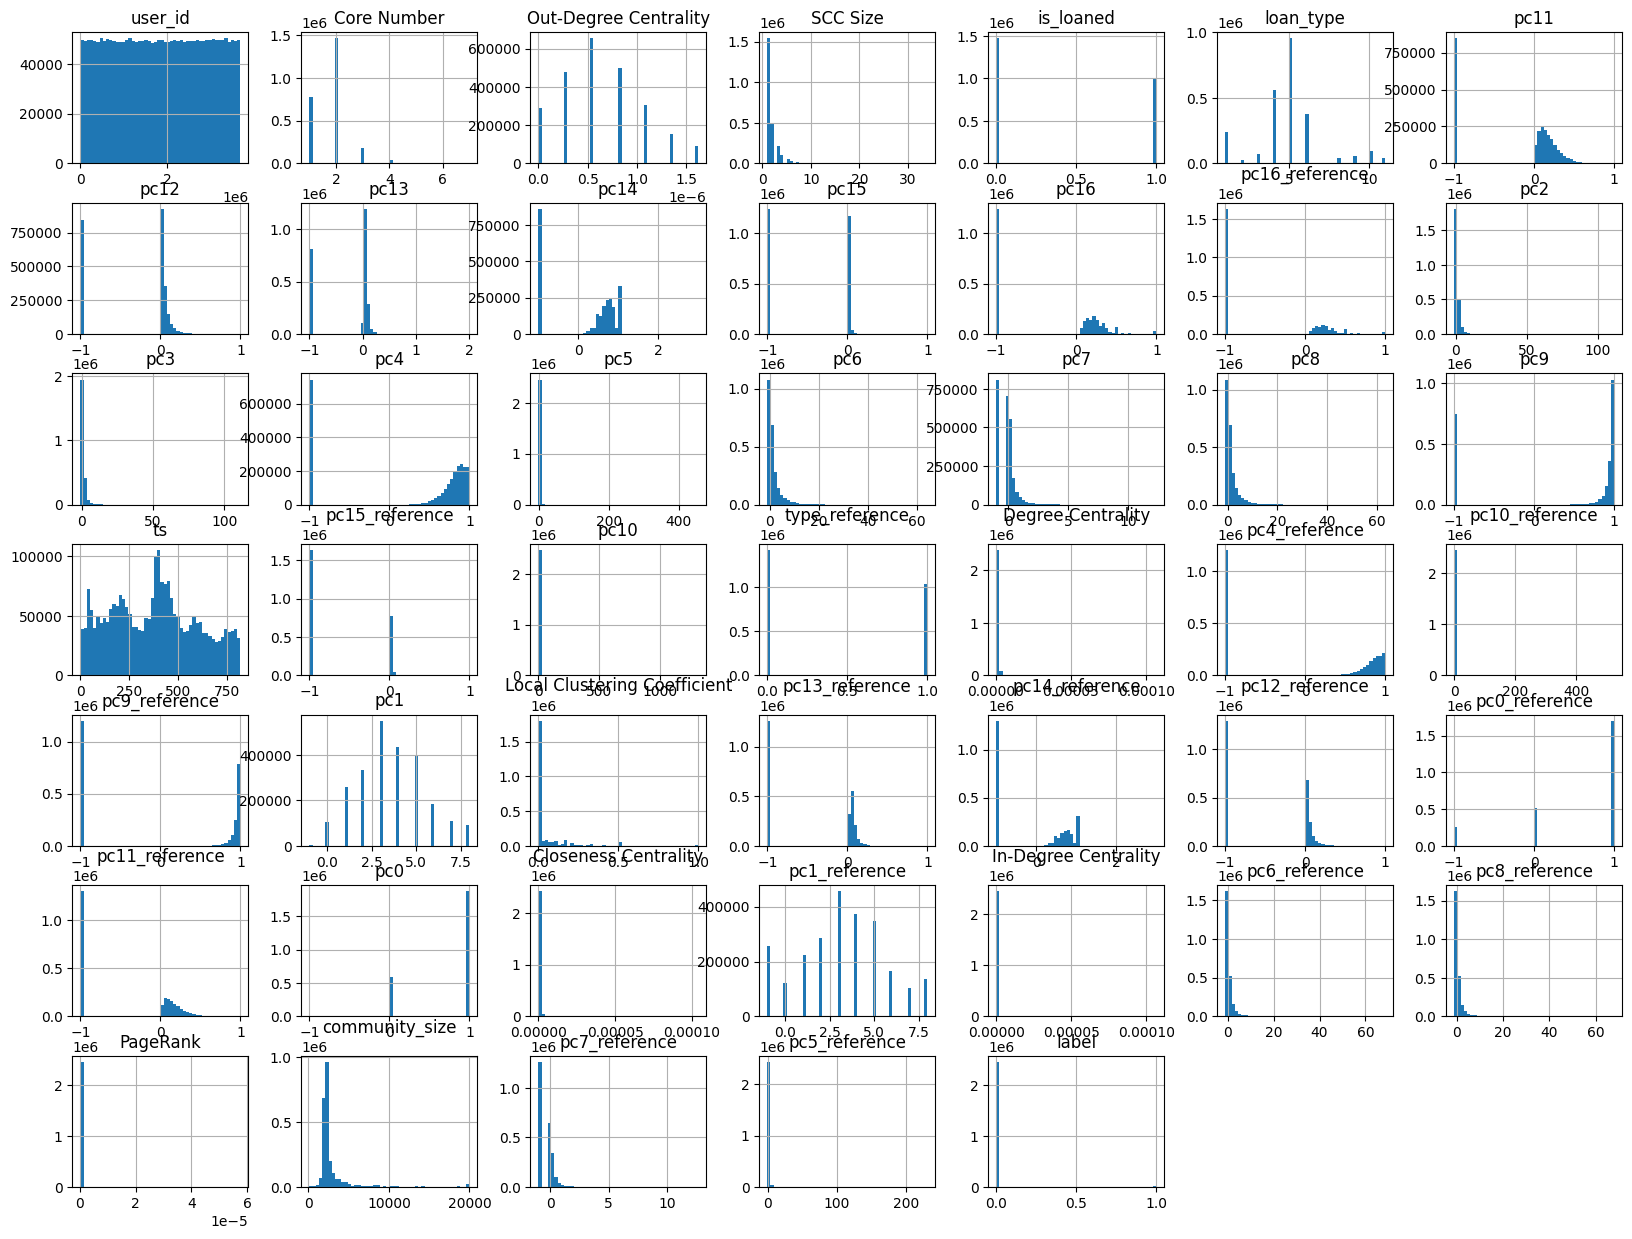

In [22]:
import matplotlib.pyplot as plt

train_split.hist(bins = 50, figsize = (20, 15))
plt.show()

21254 2447368


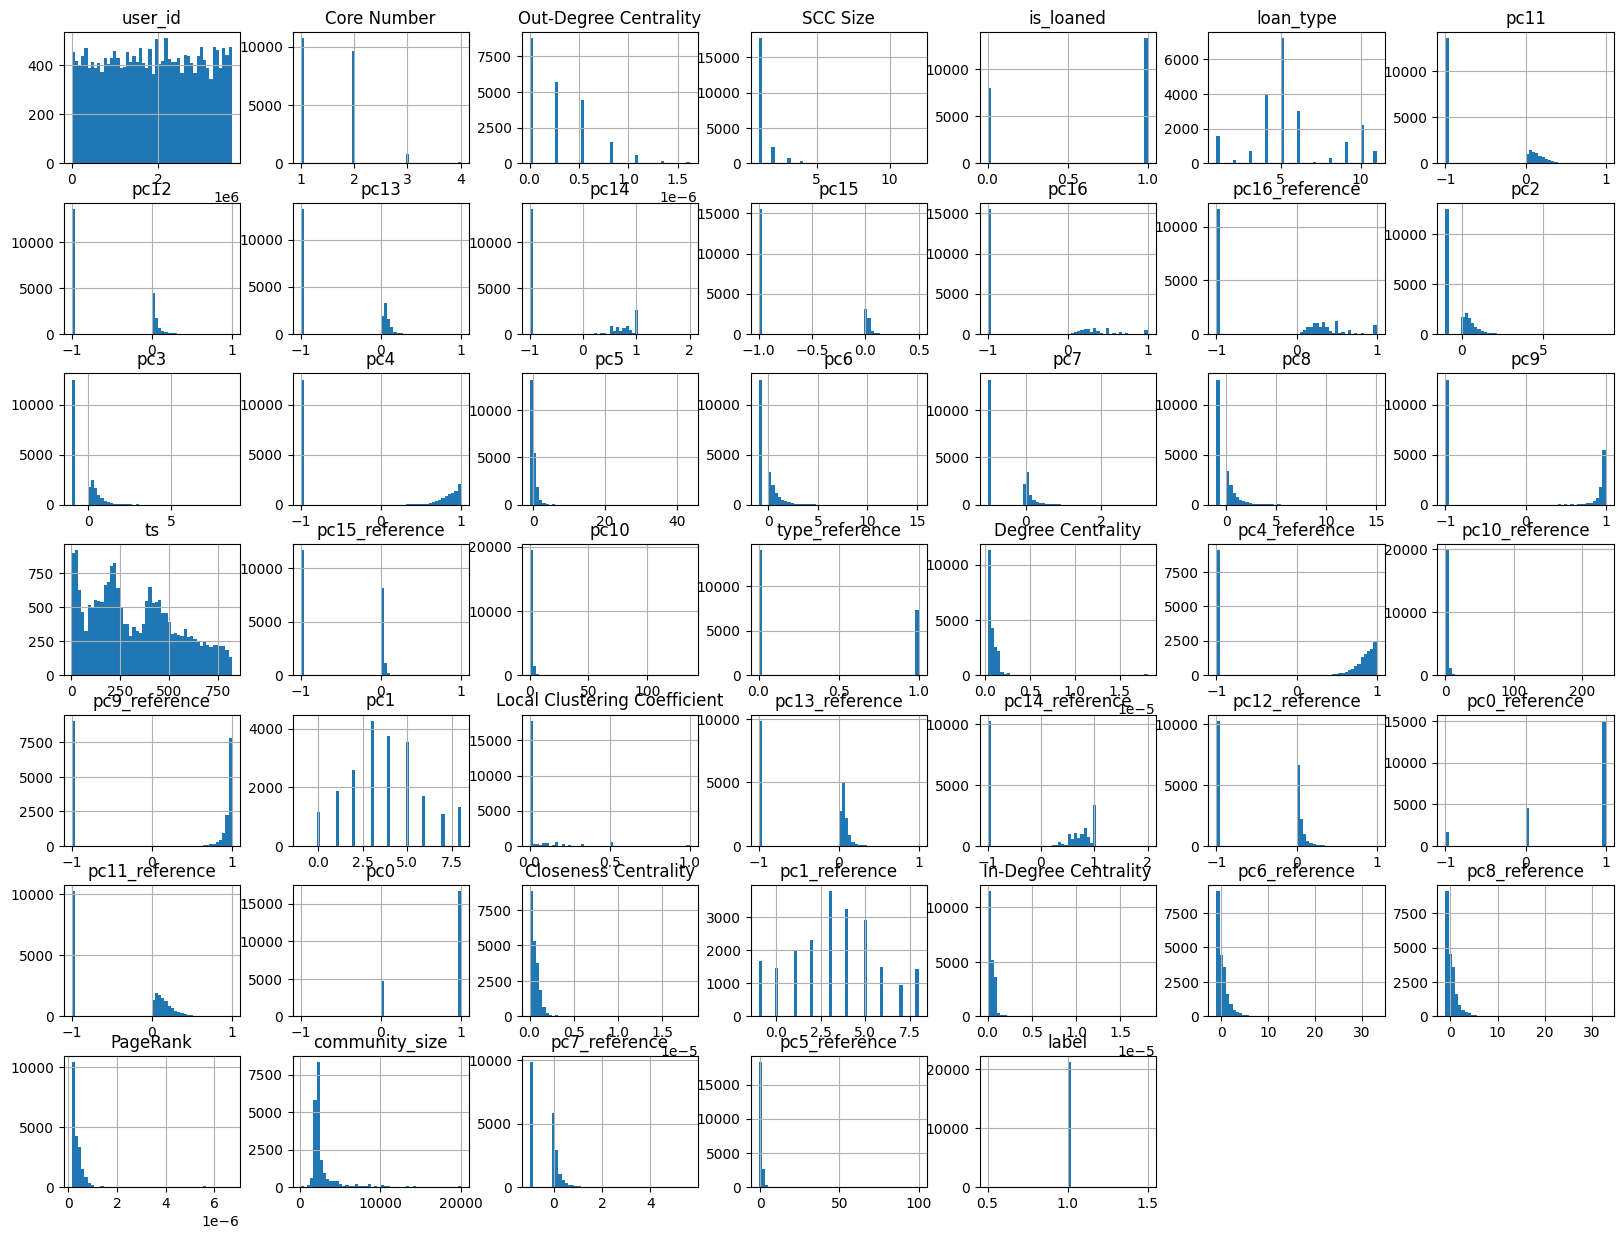

In [23]:
fraud_train_split = train_split[train_split['label'] == 1]
normal_train_split = train_split[train_split['label'] == 0]

print(len(fraud_train_split), len(normal_train_split))

fraud_train_split.hist(bins = 50, figsize = (20, 15))
plt.show()

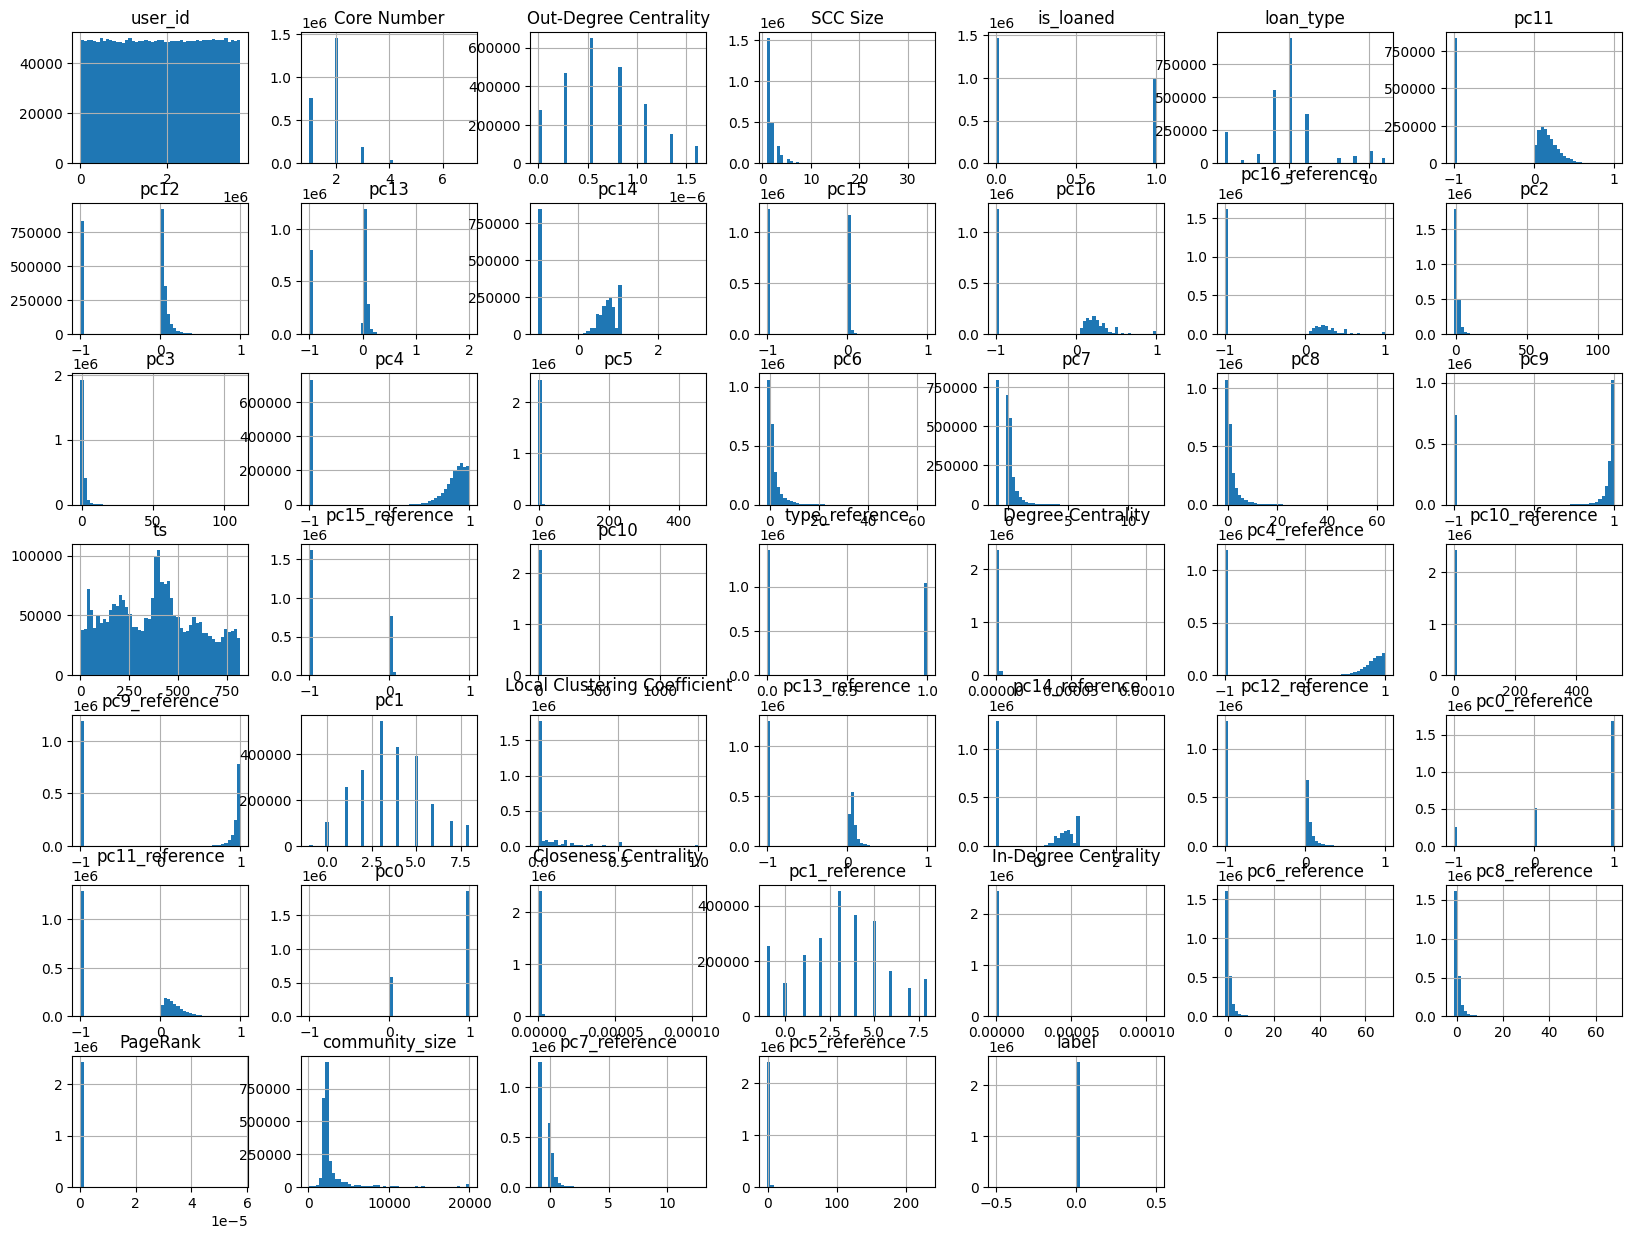

In [24]:
normal_train_split.hist(bins = 50, figsize = (20, 15))
plt.show()

From the distribution of normal and fraudster, we can see there is a distinguishable feature like PageRank, Community size that will be usefull in the next step of this process

### Heatmap
---
After filtering out unimportant features, we would need to process the redundant and highly similar features to aid in the model’s performance. Using the Correlation Heatmap, we can see the correlation between features, as well as to the label. Visualizing the Correlation Heatmap proved for use to be effective, as we found 4 redundant features, 22 features to be highly collinear to each other. 

The redundant features are determined by having the exact same collinearity measure with other features and sharing the value 1 of the collinearity measure between them. These redundant features will then be dropped.

The highly collinear features are determined by having a collinearity measure of greater than 0.95 and less than 1, or having a group/blob of collinearity in the heatmap. These collinear features will then be analyzed using the Principal Component Analysis (PCA) for dimensionality reduction. 


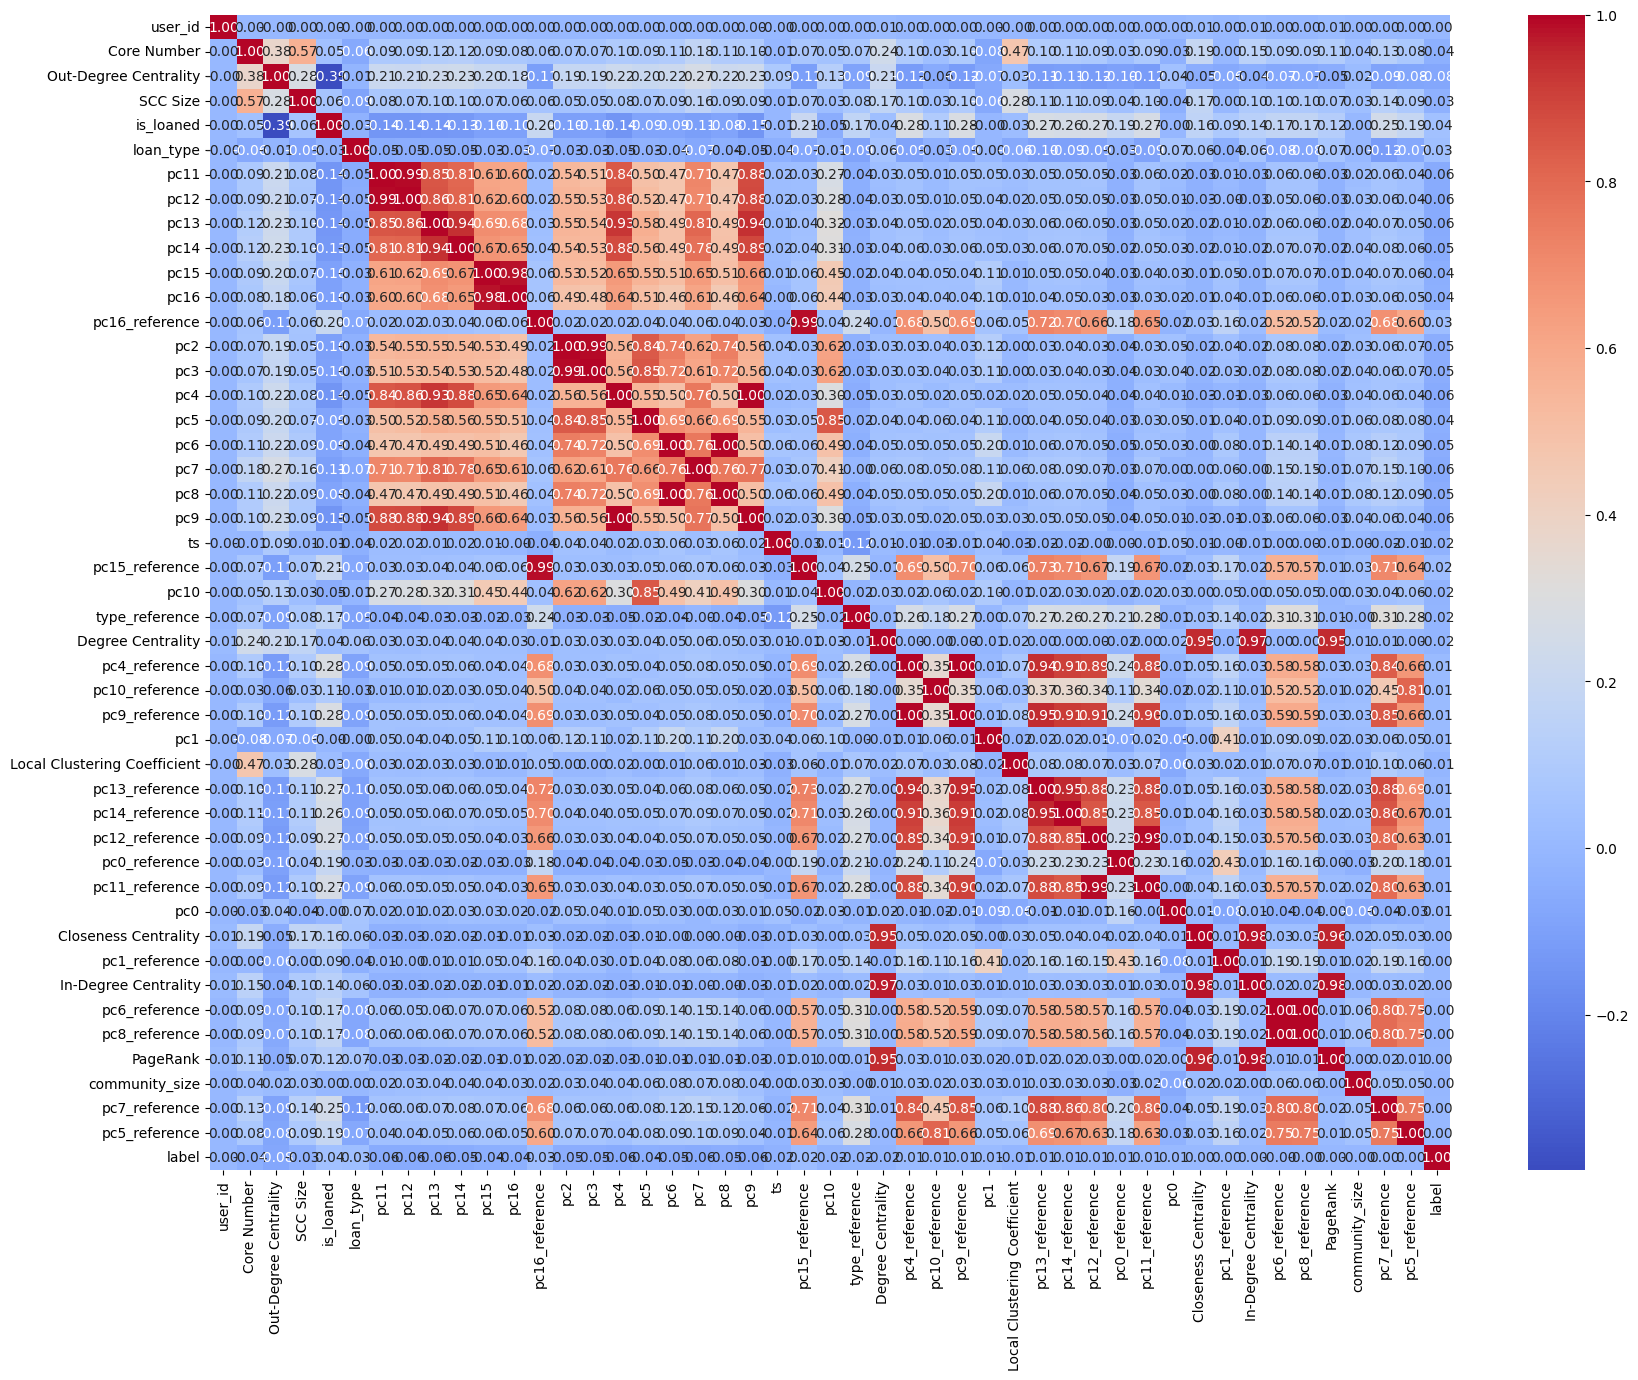

In [25]:
import seaborn as sns

correlation_matrix = train_split.corr()

plt.figure(figsize=(20, 15))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

plt.show()

In [26]:
print(test_split.shape)
test_split = test_split[['user_id', 'Core Number', 'Out-Degree Centrality', 'SCC Size',
       'is_loaned', 'loan_type', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15',
       'pc16', 'pc16_reference', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7',
       'pc8', 'pc9', 'ts', 'pc15_reference', 'pc10', 'type_reference',
       'Degree Centrality', 'pc4_reference', 'pc10_reference',
       'pc9_reference', 'pc1', 'Local Clustering Coefficient',
       'pc13_reference', 'pc14_reference', 'pc12_reference',
       'pc0_reference', 'pc11_reference', 'pc0', 'Closeness Centrality',
       'pc1_reference',  'In-Degree Centrality',
       'pc6_reference', 'pc8_reference', 'PageRank', 
       'community_size', 'pc7_reference', 'pc5_reference']]
print(test_split.shape)

(1059870, 57)
(1059870, 46)


### Scaling
---
$$x_i^{\text{scaled}}= \frac{x_i}{max(|x|)}$$

The given formula states that the data point is divided by the maximum absolute value of the set, this scaler is useful for the highly sparse data such as in this work. Small values will still be relatively small and big values will be shown, especially outliers. In addition, the range is from -1 to 1 and is useful for data with various initial scales. We chose this method because based on the distribution the data have large volume of 0 values and we also want to preserve the outlier because on this case, the majority outliers represent fraudster



In [27]:
from sklearn.preprocessing import MaxAbsScaler

x_train = train_split.drop(columns=['user_id', 'label'])
y = train_split['label']
x_test = test_split.drop(columns='user_id')

print(f"x_train shape before scaling: {x_train.shape}")
print(f"x_test shape before scaling: {x_test.shape}")

abs_scaler = MaxAbsScaler()

abs_scaler.fit(x_train)

x_train_scaled = abs_scaler.transform(x_train)
x_test_scaled = abs_scaler.transform(x_test)

x_train_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_train_df['user_id'] = train_split['user_id'].values
x_train_df['label'] = y.values

x_test_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)
x_test_df['user_id'] = test_split['user_id'].values

print(f"x_train_df shape after scaling: {x_train_df.shape}")
print(f"x_test_df shape after scaling: {x_test_df.shape}")

print(x_train_df.shape, x_test_df.shape)

x_train shape before scaling: (2468622, 45)
x_test shape before scaling: (1059870, 45)
x_train_df shape after scaling: (2468622, 47)
x_test_df shape after scaling: (1059870, 46)
(2468622, 47) (1059870, 46)


### Aggregating feature based on user_id
---
As multiple users are doing multiple transactions recorded on loan activities, the features starting from the standard user and reference features (PC0 - PC16), graph features, and community features are aggregated based on each user ID to the average. **This gave a convolution process in which the kernel used would be averaging all of the neighboring nodes' features**

In [28]:
def agg_avg(df,type):
    columns_to_average = [col for col in df.columns if col not in ['user_id', 'label']]
    if type=='train':
        grouped_df = df.groupby('user_id').agg({
        **{col: 'mean' for col in columns_to_average},
        'label': 'last'  
        })
    else:
        grouped_df = df.groupby('user_id').agg({
        **{col: 'mean' for col in columns_to_average},  
        })
    return grouped_df.sort_values(by='user_id').reset_index()

train_agg = agg_avg(x_train_df,'train')
test_agg = agg_avg(x_test_df,'test')

train_label = train_agg['label']
test_index = test_agg['user_id']

print(train_agg.shape)
print(test_agg.shape)

test_agg.drop(columns='user_id',inplace=True)
train_agg.drop(columns='user_id',inplace=True)

(857899, 47)
(367702, 46)


In [29]:
train_agg

Core Number  Out-Degree Centrality  SCC Size  is_loaned  loan_type  \
0          0.142857               0.000000  0.029412   1.000000   0.363636   
1          0.142857               0.333333  0.029412   0.333333   0.484848   
2          0.428571               0.500000  0.088235   0.400000   0.418182   
3          0.285714               0.333333  0.058824   0.500000   0.386364   
4          0.285714               0.166667  0.029412   0.666667   0.272727   
...             ...                    ...       ...        ...        ...   
857894     0.142857               0.166667  0.029412   0.500000   0.454545   
857895     0.142857               0.500000  0.029412   0.000000   0.454545   
857896     0.142857               0.166667  0.029412   0.500000   0.409091   
857897     0.142857               0.166667  0.029412   0.000000   0.545455   
857898     0.285714               0.166667  0.058824   0.500000   0.090909   

            pc11      pc12      pc13      pc14      pc15      pc16  \
0       0.072727  0.023077  0.039216  0.250000  0.018182  0.250000   
1       0.151163  0.014366  0.027397  0.166667  0.011628  0.250000   
2       0.372624  0.048218  0.027273  0.259259  0.003802  0.111111   
3      -1.000000 -1.000000 -0.500000 -0.333333 -1.000000 -1.000000   
4       0.319149  0.133333  0.015625 -0.333333 -1.000000 -1.000000   
...          ...       ...       ...       ...       ...       ...   
857894  0.157895  0.024911  0.015625  0.333333 -1.000000 -1.000000   
857895  0.102339  0.010133  0.034202  0.285714  0.011696  0.190476   
857896  0.048499  0.012201  0.029126  0.152778  0.004619  0.083333   
857897  0.245783  0.031592  0.030351  0.245614  0.009639  0.210526   
857898 -1.000000 -1.000000 -0.500000 -0.333333 -1.000000 -1.000000   

        pc16_reference       pc2       pc3       pc4       pc5       pc6  \
0             -1.00000  0.002459  0.002288  0.927273  0.000877  0.004055   
1             -1.00000  0.003846  0.003274  0.848837  0.000877  0.019542   
2             -0.75000  0.011760  0.007401  0.627376  0.001972  0.037196   
3             -1.00000 -0.008943 -0.008971 -1.000000 -0.002192 -0.015596   
4             -0.04902  0.002102  0.001435  0.680851  0.000219  0.001872   
...                ...       ...       ...       ...       ...       ...   
857894        -0.37500  0.001699  0.001435  0.842105  0.000219  0.004382   
857895        -1.00000  0.015293  0.013770  0.897661  0.004602  0.058485   
857896        -1.00000  0.019362  0.018479  0.951501  0.005260  0.034514   
857897         0.25000  0.018557  0.014039  0.754217  0.004164  0.051342   
857898        -1.00000 -0.008943 -0.008971 -1.000000 -0.002192 -0.015596   

             pc7       pc8       pc9        ts  pc15_reference      pc10  \
0       0.003242  0.004005  0.976923  0.628502       -1.000000  0.000762   
1       0.017021  0.019475  0.985634  0.402355       -1.000000  0.000762   
2       0.010374  0.035795  0.951782  0.368088       -0.799125  0.000762   
3      -0.081050 -0.015769 -1.000000  0.662911       -1.000000  0.000000   
4       0.000162  0.001640  0.866667  0.416565       -0.322421  0.000000   
...          ...       ...       ...       ...             ...       ...   
857894  0.000405  0.004321  0.975089  0.312424       -0.493056  0.000000   
857895  0.055682  0.058534  0.989867  0.365814       -1.000000  0.003046   
857896  0.005268  0.034471  0.987799  0.227162       -1.000000  0.001523   
857897  0.027719  0.050271  0.968408  0.478685        0.012346  0.003046   
857898 -0.081050 -0.015769 -1.000000  0.228380       -1.000000  0.000000   

        type_reference  Degree Centrality  pc4_reference  pc10_reference  \
0             0.000000           0.002532       0.634146        0.000000   
1             0.333333           0.007595      -0.442029        0.000000   
2             0.200000           0.012658      -0.612035        0.001527   
3             0.250000           0.010127      -0.506944        0.000000   
4             0.666667  

In [30]:
test_agg

Core Number  Out-Degree Centrality  SCC Size  is_loaned  loan_type  \
0          0.142857               0.000000  0.029412   1.000000   0.363636   
1          0.285714               0.333333  0.058824   0.333333   0.212121   
2          0.142857               0.166667  0.029412   0.000000   0.454545   
3          0.285714               0.000000  0.029412   1.000000   0.363636   
4          0.285714               0.333333  0.058824   0.500000   0.454545   
...             ...                    ...       ...        ...        ...   
367697     0.285714               0.000000  0.029412   1.000000   0.363636   
367698     0.285714               0.333333  0.058824   0.333333   0.272727   
367699     0.142857               0.500000  0.029412   0.000000   0.757576   
367700     0.285714               0.500000  0.029412   0.000000   0.545455   
367701     0.428571               0.500000  0.205882   0.400000   0.327273   

            pc11      pc12      pc13      pc14      pc15      pc16  \
0      -1.000000 -1.000000 -0.500000 -0.333333 -1.000000 -1.000000   
1       0.056180  0.006386  0.047619  0.250000  0.022472  0.250000   
2       0.357143  0.137104  0.013889  0.166667  0.002976  0.166667   
3       0.418605  0.327059  0.025714  0.111111  0.003322  0.111111   
4       0.513575  0.247591  0.023256  0.266667  0.004525  0.200000   
...          ...       ...       ...       ...       ...       ...   
367697 -1.000000 -1.000000 -0.500000 -0.333333 -1.000000 -1.000000   
367698 -1.000000 -1.000000 -0.500000 -0.333333 -1.000000 -1.000000   
367699  0.113636  0.108108  0.012821 -0.333333 -1.000000 -1.000000   
367700  0.059426  0.039837  0.019608  0.259259  0.014344  0.388889   
367701  0.108553  0.008014  0.035055  0.263158  0.009868  0.157895   

        pc16_reference       pc2       pc3       pc4       pc5       pc6  \
0             0.125000 -0.008943 -0.008971 -1.000000 -0.002192 -0.015596   
1            -0.200000  0.003980  0.003768  0.943820  0.001753  0.012212   
2            -1.000000  0.015025  0.009688  0.642857  0.001315  0.018201   
3             0.225000  0.013460  0.007849  0.581395  0.001972  0.006628   
4            -0.714286  0.019765  0.009643  0.486425  0.002192  0.021039   
...                ...       ...       ...       ...       ...       ...   
367697       -1.000000 -0.008943 -0.008971 -1.000000 -0.002192 -0.015596   
367698       -1.000000 -0.008943 -0.008971 -1.000000 -0.002192 -0.015596   
367699       -1.000000  0.001968  0.001749  0.886364  0.000219  0.001154   
367700       -0.631579  0.021822  0.020588  0.940574  0.003945  0.091611   
367701        0.008059  0.013594  0.012155  0.891447  0.004164  0.072007   

             pc7       pc8       pc9        ts  pc15_reference      pc10  \
0      -0.081050 -0.015769 -1.000000  0.550548        0.010870  0.000000   
1       0.018966  0.012268  0.993614  0.345108       -0.323944  0.001523   
2       0.003728  0.015879  0.862896  0.073082       -1.000000  0.000762   
3       0.000973  0.004510  0.672941  0.302071        0.010789  0.000762   
4       0.007051  0.016005  0.752409  0.629720       -0.749104  0.001523   
...          ...       ...       ...       ...             ...       ...   
367697 -0.081050 -0.015769 -1.000000  0.712546       -1.000000  0.000000   
367698 -0.081050 -0.015769 -1.000000  0.145351       -1.000000  0.000000   
367699  0.000162  0.001041  0.891892  0.120179       -1.000000  0.000000   
367700  0.020101  0.088937  0.960163  0.361754       -0.665201  0.005331   
367701  0.087048  0.072222  0.991986  0.403410       -0.190006  0.002285   

        type_reference  Degree Centrality  pc4_reference  pc10_reference  \
0             1.000000           0.002532       1.000000        0.001908   
1             0.666667           0.007595       0.220657        0.001272   
2             1.000000           0.002532       0.826446        0.000000   
3             0.000000           0.005063       0.795731        0.002863   
4             0.750000  

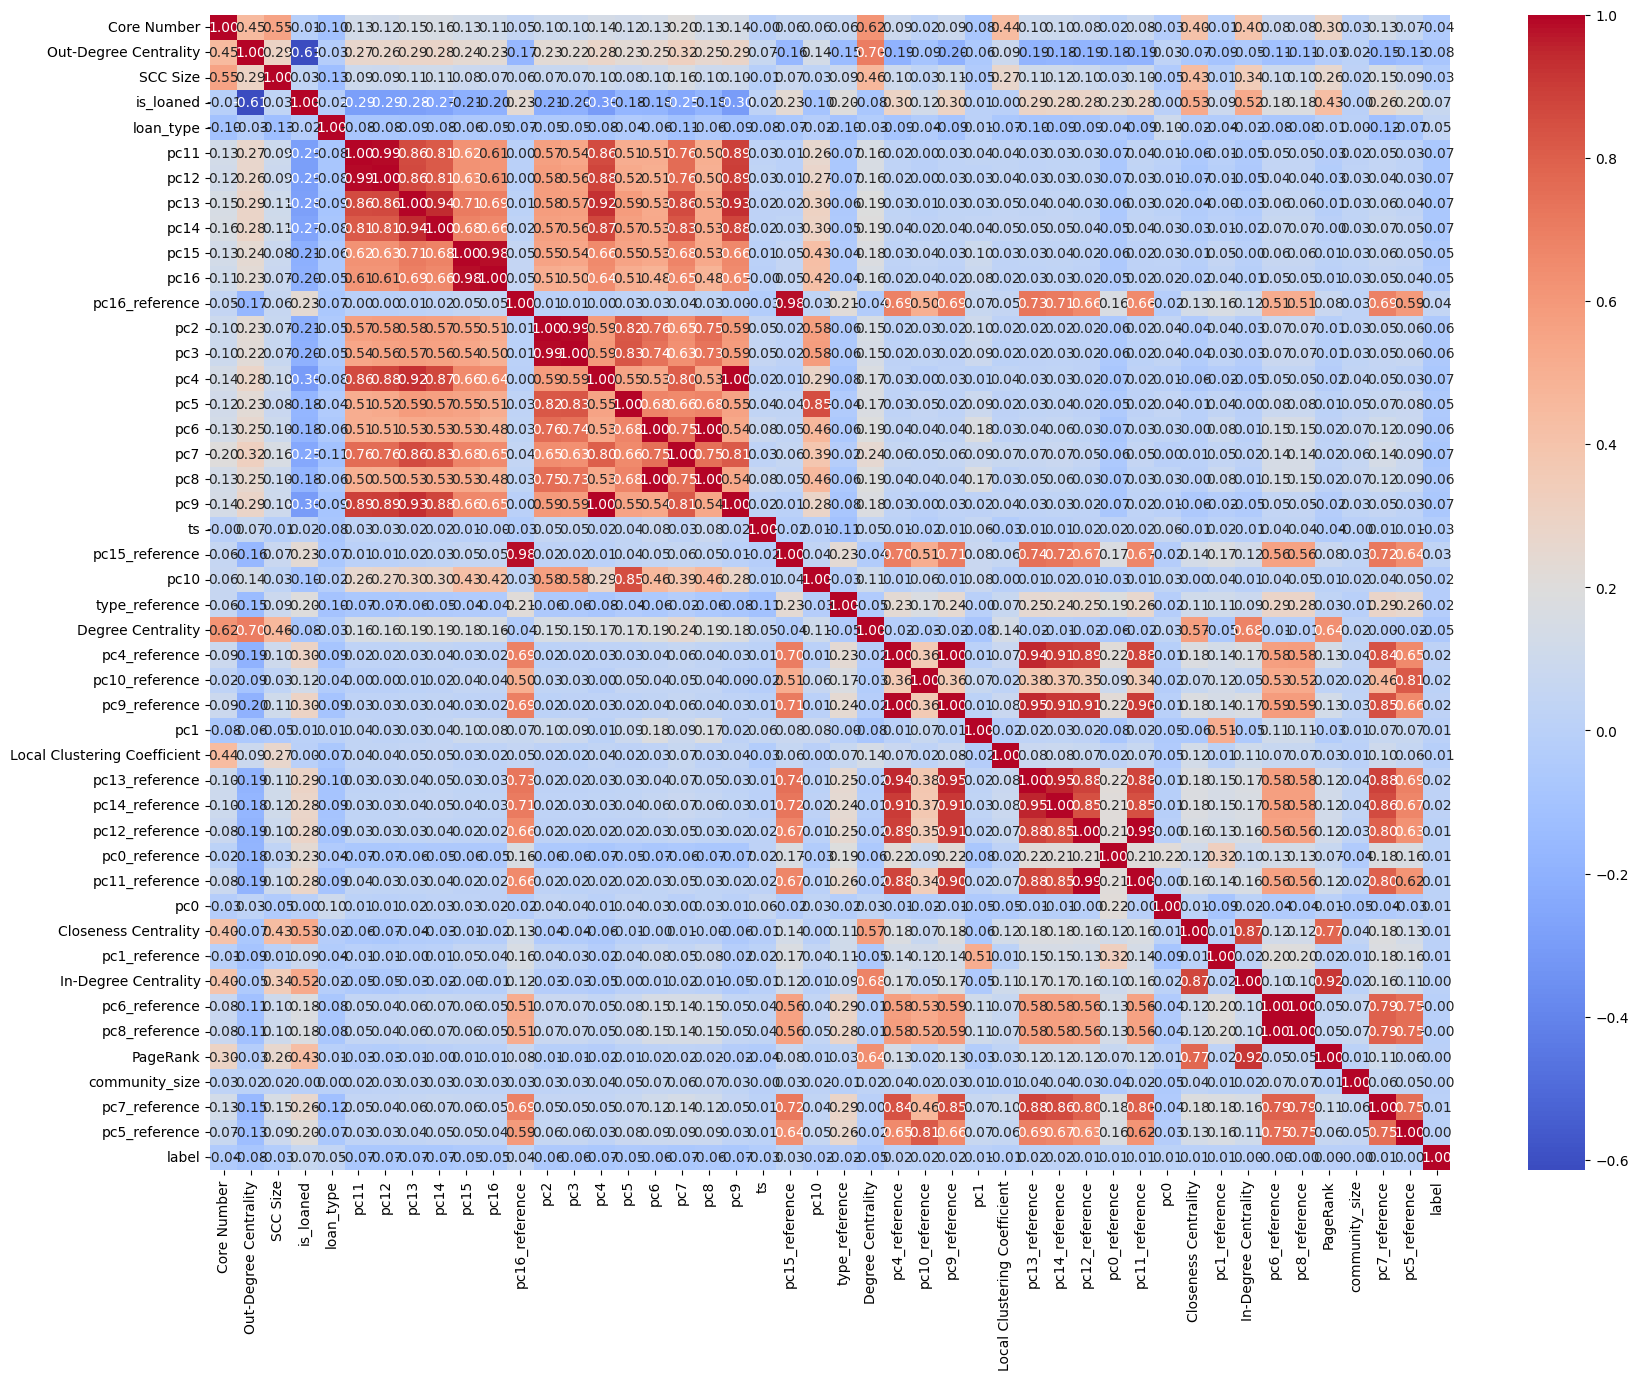

In [31]:
correlation_matrix = train_agg.corr()

plt.figure(figsize=(20, 15))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

plt.show()

Based on the HeatMap above we can conclude there are still exist some highly co-linear features that we can perform PCA on, and some redundant features that can be dropped. 

In [32]:
print(train_agg.shape, test_agg.shape)

columns_to_drop = [ 'pc8_reference', 'pc9_reference']
train_agg = train_agg.drop(columns=columns_to_drop)
test_agg = test_agg.drop(columns=columns_to_drop)

print(train_agg.shape, test_agg.shape)

(857899, 46) (367702, 45)
(857899, 44) (367702, 43)


### Principal Component Analysis
---
To ensure the integrity of data but still retain the diverse information, our team chose to do non aggresive PCA with apllying the transformation only on the high colinearity feature like
1. 'pc15_reference' and 'pc16_reference' into 1 feature
2. 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16' into 7 features based on cumulative explain variance

In [37]:
pca = PCA(n_components = 2, random_state=123)
pca.fit(train_agg[['pc15_reference', 'pc16_reference']])
princ_comp = pca.transform(train_agg[['pc15_reference', 'pc16_reference']])

pca.explained_variance_ratio_.round(3)

array([0.993, 0.007])

In [38]:
print('train_agg shape: ', train_agg.shape)
print('test_agg shape: ', test_agg.shape)

pca = PCA(n_components=1, random_state=123)
pca.fit(train_agg[['pc15_reference', 'pc16_reference']])

train_agg['pc15-16_reference'] = pca.transform(train_agg.loc[:, ('pc15_reference', 'pc16_reference')]).flatten()
test_agg['pc15-16_reference'] = pca.transform(test_agg.loc[:, ('pc15_reference', 'pc16_reference')]).flatten()

train_agg.drop(['pc15_reference', 'pc16_reference'], axis=1, inplace=True)
test_agg.drop(['pc15_reference', 'pc16_reference'], axis=1, inplace=True)

print('train_agg shape: ', train_agg.shape)
print('test_agg shape: ', test_agg.shape)

train_agg shape:  (857899, 44)
test_agg shape:  (367702, 43)
train_agg shape:  (857899, 43)
test_agg shape:  (367702, 42)


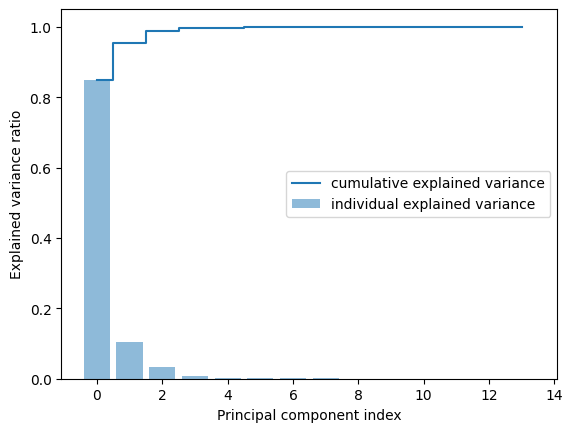

[0.849 0.954 0.988 0.995 0.997 0.998 0.999 1.    1.    1.    1.    1.
 1.    1.   ]


In [39]:
pca_columns_1 = ['pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16']

# PCA pertama, untuk data akademik saat belajar
pca = PCA(n_components = len(pca_columns_1), random_state=123)
pca.fit(train_agg[pca_columns_1])
princ_comp = pca.transform(train_agg[pca_columns_1])
 
var_exp = pca.explained_variance_ratio_.round(3)
cum_var_exp = np.cumsum(var_exp)
 
plt.bar(range(len(pca_columns_1)), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(pca_columns_1)), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='center right')
plt.show()
print(cum_var_exp)

Based on the cumulative explained variance, we decide to use 7 component out of 14 with cumulative score of 0.999

In [40]:
print('train_agg shape: ', train_agg.shape)
print('test_agg shape: ', test_agg.shape)

pca = PCA(n_components=7, random_state=123)
pca.fit(train_agg[pca_columns_1])

train_agg_pca = pca.transform(train_agg[pca_columns_1])
test_agg_pca = pca.transform(test_agg[pca_columns_1])

train_agg_pca_df = pd.DataFrame(train_agg_pca, columns=[f'agg-pc{i+1}-user' for i in range(train_agg_pca.shape[1])])
test_agg_pca_df = pd.DataFrame(test_agg_pca, columns=[f'agg-pc{i+1}-user' for i in range(test_agg_pca.shape[1])])

train_agg = pd.concat([train_agg.reset_index(drop=True), train_agg_pca_df], axis=1)
test_agg = pd.concat([test_agg.reset_index(drop=True), test_agg_pca_df], axis=1)

train_agg.drop(columns=pca_columns_1, inplace=True)
test_agg.drop(columns=pca_columns_1, inplace=True)

print('train_agg shape: ', train_agg.shape)
print('test_agg shape: ', test_agg.shape)

train_agg shape:  (857899, 43)
test_agg shape:  (367702, 42)
train_agg shape:  (857899, 36)
test_agg shape:  (367702, 35)


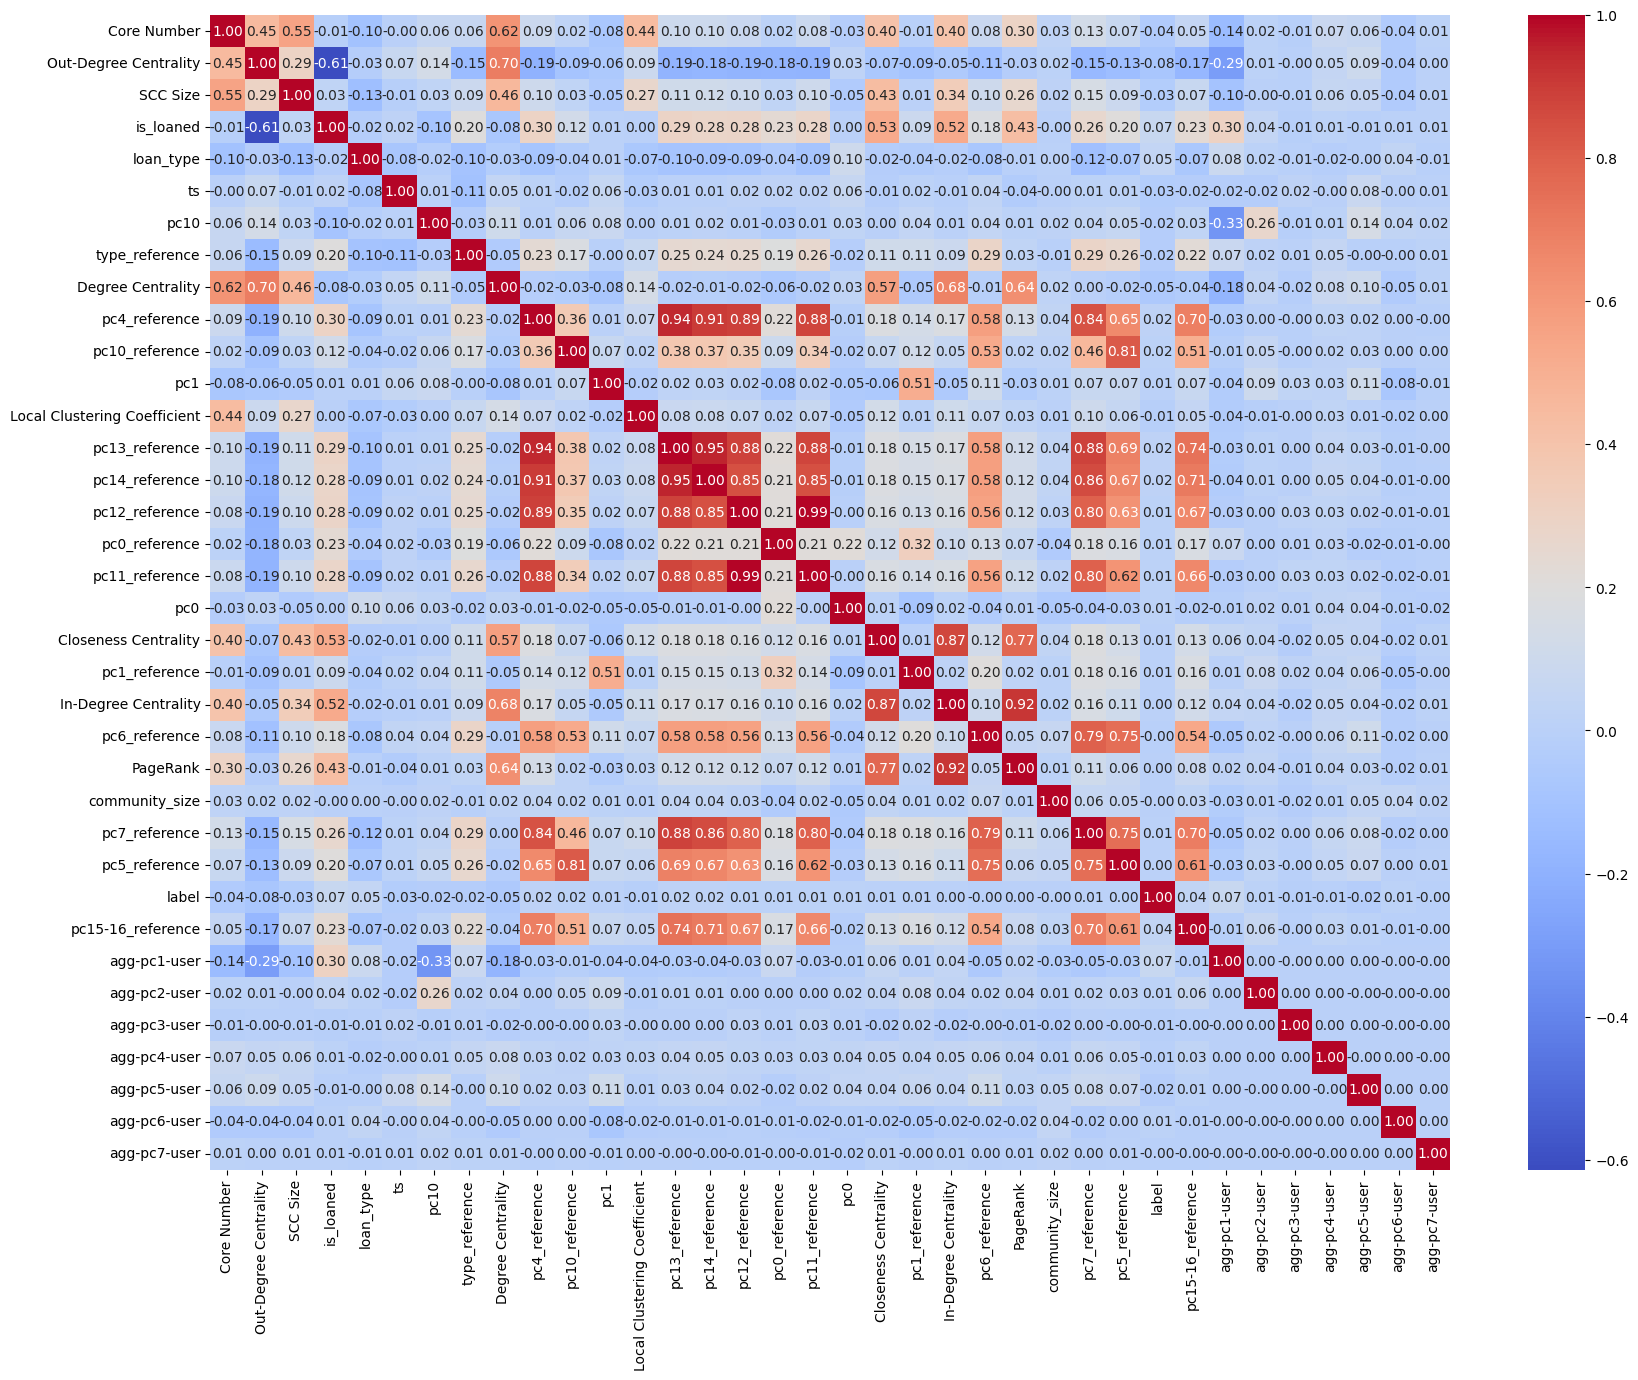

In [41]:
correlation_matrix = train_agg.corr()

plt.figure(figsize=(20, 15))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

plt.show()

### Outliers removal - Isolation forest
---

![Isolation Forest](https://machinelearninggeek.com/wp-content/uploads/2020/10/image-78.png)

src = [Machine Learning Geek](https://machinelearninggeek.com/outlier-detection-using-isolation-forests/)

Outlier Reduction using Isolation Forest
After getting the final aggregated, important features of each user, we removed the outliers of class 0 (normal) to further clean the data. It must be emphasized that we split the data into class 0 and class 1 (fraudulent) and performed the outlier reduction on the class 0 split. The reasons for this are as follows. 
1. Class 1 takes up less than 1 percent of the dataset. Reducing any number from class 1 will put the model at risk of underfitting. 
2. Based on domain knowledge, the majority of outliers is representing the outliers and risking to remove large portion of fraudulent samples if apple Isolation Forest to the fraudulent and non fraudulent data


In [42]:
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle

non_fraud_data = train_agg[train_agg.label == 0].drop(columns=['label']).values
fraud_data = train_agg[train_agg.label == 1].drop(columns=['label']).values
total_samples = len(non_fraud_data) + len(fraud_data)
contamination = len(fraud_data) / total_samples

iso_forest = IsolationForest(contamination=0.01, #'auto',
                             random_state=42,
                             n_estimators=100)

outlier_labels = iso_forest.fit_predict(non_fraud_data)

inlier_indices = np.where(outlier_labels == 1)[0]

non_fraud_data_cleaned = non_fraud_data[inlier_indices]

print(train_agg.shape, test_agg.shape)

non_fraud_data_cleaned = pd.DataFrame(non_fraud_data_cleaned, columns=test_agg.columns)
fraud = pd.DataFrame(fraud_data, columns=test_agg.columns)

print(non_fraud_data_cleaned.shape, fraud.shape)

(857899, 36) (367702, 35)
(838571, 35) (10857, 35)


In [43]:
non_fraud_data_cleaned['label'] = 0
fraud['label'] = 1

print(non_fraud_data_cleaned.shape)
print(fraud.shape)

(838571, 36)
(10857, 36)


In [44]:
train_agg = pd.concat([non_fraud_data_cleaned, fraud], axis=0, ignore_index=True)
train_agg = shuffle(train_agg, random_state=42)
train_agg.reset_index(drop=True, inplace=True)

train_agg

Core Number  Out-Degree Centrality  SCC Size  is_loaned  loan_type  \
0          0.285714               0.500000  0.029412   0.000000   0.727273   
1          0.285714               0.166667  0.029412   0.500000   0.272727   
2          0.428571               0.833333  0.205882   0.166667   0.393939   
3          0.285714               0.166667  0.029412   0.500000   0.409091   
4          0.142857               0.166667  0.029412   0.500000   0.454545   
...             ...                    ...       ...        ...        ...   
849423     0.142857               0.333333  0.029412   0.000000   0.272727   
849424     0.142857               0.166667  0.029412   0.000000   0.454545   
849425     0.142857               0.000000  0.029412   1.000000   0.454545   
849426     0.142857               0.166667  0.029412   0.000000   0.545455   
849427     0.285714               0.333333  0.058824   0.600000   0.218182   

              ts      pc10  type_reference  Degree Centrality  pc4_reference  \
0       0.425903  0.003046             0.0           0.007595      -1.000000   
1       0.659562  0.002285             0.0           0.005063      -1.000000   
2       0.523346  0.000000             0.0           0.015190      -0.690476   
3       0.453106  0.000000             0.5           0.005063      -1.000000   
4       0.492692  0.000762             0.5           0.005063       0.763158   
...          ...       ...             ...                ...            ...   
849423  0.700365  0.000000             0.0           0.005063      -1.000000   
849424  0.550548  0.000762             0.0           0.002532      -1.000000   
849425  0.354446  0.000000             0.5           0.005063       0.925182   
849426  0.918392  0.000762             0.0           0.002532      -1.000000   
849427  0.392692  0.003808             0.8           0.012658       0.051645   

        pc10_reference    pc1  Local Clustering Coefficient  pc13_reference  \
0             0.000000  0.375                      0.000000       -1.000000   
1             0.000000  0.375                      0.500000       -1.000000   
2             0.000000  0.375                      0.035714       -0.823232   
3             0.000000  0.500                      0.000000       -1.000000   
4             0.004771  0.500                      0.000000       -0.478814   
...                ...    ...                           ...             ...   
849423        0.000000  0.500                      0.000000       -1.000000   
849424        0.000000  0.375                      0.000000       -1.000000   
849425        0.002863  0.500                      0.000000        0.123810   
849426        0.000000  0.500                      0.000000       -1.000000   
849427        0.001908  0.625                      0.166667       -0.359101   

        pc14_reference  pc12_reference  pc0_reference  pc11_reference  pc0  \
0            -0.333333       -1.000000      -0.333333       -1.000000  1.0   
1            -0.333333       -1.000000       1.000000       -1.000000  0.0   
2            -0.222222       -0.820675       0.666667       -0.809524  1.0   
3            -0.333333       -1.000000       0.000000       -1.000000  1.0   
4            -0.100000        0.066570       0.000000        0.236842  1.0   
...                ...             ...            ...             ...  ...   
849423       -0.333333       -1.000000       1.000000       -1.000000  0.0   
849424       -0.333333       -1.000000       1.000000       -1.000000  1.0   
849425        0.303030        0.019717       1.000000        0.074818  1.0   
849426       -0.333333       -1.000000      -1.000000       -1.000000  1.0   
849427       -0.026667       -0.379053       0.200000       -0.251645  1.0   

        Closeness Centrality  pc1_reference  In-Degree Centrality  \
0                   0.000000       0.208333              0.000000   
1                   0.002594       0.500000              0.002532   
2                

### Anomaly Score
--- 
Besides removing outliers of non fraud data, we also apply Isolation Forest to do feature engineering. The process is done with using the overall data of both fraud and non-fraud users, we want to find the isolation forest score or initial probability of how likely a user is to be a fraud (or to be an anomaly).

In [45]:
X = train_agg.drop(columns=['label'])
y = train_agg['label']

contamination_factor = y.mean()  
iso_forest = IsolationForest(contamination=contamination_factor, random_state=42)
iso_forest.fit(X)

anomaly_scores = iso_forest.decision_function(X)
anomaly_scores_test = iso_forest.decision_function(test_agg.values)

train_agg['iso_forest_score'] = anomaly_scores
test_agg['iso_forest_score'] = anomaly_scores_test

train_agg

c:\Users\Yosef\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\Yosef\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Core Number  Out-Degree Centrality  SCC Size  is_loaned  loan_type  \
0          0.285714               0.500000  0.029412   0.000000   0.727273   
1          0.285714               0.166667  0.029412   0.500000   0.272727   
2          0.428571               0.833333  0.205882   0.166667   0.393939   
3          0.285714               0.166667  0.029412   0.500000   0.409091   
4          0.142857               0.166667  0.029412   0.500000   0.454545   
...             ...                    ...       ...        ...        ...   
849423     0.142857               0.333333  0.029412   0.000000   0.272727   
849424     0.142857               0.166667  0.029412   0.000000   0.454545   
849425     0.142857               0.000000  0.029412   1.000000   0.454545   
849426     0.142857               0.166667  0.029412   0.000000   0.545455   
849427     0.285714               0.333333  0.058824   0.600000   0.218182   

              ts      pc10  type_reference  Degree Centrality  pc4_reference  \
0       0.425903  0.003046             0.0           0.007595      -1.000000   
1       0.659562  0.002285             0.0           0.005063      -1.000000   
2       0.523346  0.000000             0.0           0.015190      -0.690476   
3       0.453106  0.000000             0.5           0.005063      -1.000000   
4       0.492692  0.000762             0.5           0.005063       0.763158   
...          ...       ...             ...                ...            ...   
849423  0.700365  0.000000             0.0           0.005063      -1.000000   
849424  0.550548  0.000762             0.0           0.002532      -1.000000   
849425  0.354446  0.000000             0.5           0.005063       0.925182   
849426  0.918392  0.000762             0.0           0.002532      -1.000000   
849427  0.392692  0.003808             0.8           0.012658       0.051645   

        pc10_reference    pc1  Local Clustering Coefficient  pc13_reference  \
0             0.000000  0.375                      0.000000       -1.000000   
1             0.000000  0.375                      0.500000       -1.000000   
2             0.000000  0.375                      0.035714       -0.823232   
3             0.000000  0.500                      0.000000       -1.000000   
4             0.004771  0.500                      0.000000       -0.478814   
...                ...    ...                           ...             ...   
849423        0.000000  0.500                      0.000000       -1.000000   
849424        0.000000  0.375                      0.000000       -1.000000   
849425        0.002863  0.500                      0.000000        0.123810   
849426        0.000000  0.500                      0.000000       -1.000000   
849427        0.001908  0.625                      0.166667       -0.359101   

        pc14_reference  pc12_reference  pc0_reference  pc11_reference  pc0  \
0            -0.333333       -1.000000      -0.333333       -1.000000  1.0   
1            -0.333333       -1.000000       1.000000       -1.000000  0.0   
2            -0.222222       -0.820675       0.666667       -0.809524  1.0   
3            -0.333333       -1.000000       0.000000       -1.000000  1.0   
4            -0.100000        0.066570       0.000000        0.236842  1.0   
...                ...             ...            ...             ...  ...   
849423       -0.333333       -1.000000       1.000000       -1.000000  0.0   
849424       -0.333333       -1.000000       1.000000       -1.000000  1.0   
849425        0.303030        0.019717       1.000000        0.074818  1.0   
849426       -0.333333       -1.000000      -1.000000       -1.000000  1.0   
849427       -0.026667       -0.379053       0.200000       -0.251645  1.0   

        Closeness Centrality  pc1_reference  In-Degree Centrality  \
0                   0.000000       0.208333              0.000000   
1                   0.002594       0.500000              0.002532   
2                

## Modelling
---
Extreme Gradient Boosting (XGB) is used after running several experimentations with different classifiers, including Gaussian Naive Bayes [10] the best modeling performance and efficiency trade-off. We use a boosting algorithm as a method to help learn a model learning from the mistakes of the previous model. XGB classifier itself is a robust model for overfitting, thus chosen in this process [11]

![boosting](https://media.geeksforgeeks.org/wp-content/uploads/20210707140911/Boosting.png)

src = [GeeksForGeeks](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)


### Baseline
---

In [77]:
# original data, baseline XGB

from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, average_precision_score

x_train_fin = train_agg.drop(columns=['label'])
y_train_fin = train_agg['label']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
modelb = XGBClassifier(random_state=42,eval_metric='map',max_delta_step=1)
scorer = make_scorer(average_precision_score, needs_proba=True)
cv_scores = cross_val_score(modelb, x_train_fin, y_train_fin, cv=kf, scoring=scorer)

print("Cross-validation Mean Average Precision scores:", cv_scores)
print("Mean cross-validation Mean Average Precision score:", cv_scores.mean())
print("Standard deviation of cross-validation Mean Average Precision score:", cv_scores.std())

modelb.fit(x_train_fin, y_train_fin)
y_pred_proba = modelb.predict_proba(test_agg)[:, 1]
print("Predictions on test set:", y_pred_proba)

Cross-validation Mean Average Precision scores: [0.05229258 0.06020089 0.05682827 0.05728795 0.05559558]
Mean cross-validation Mean Average Precision score: 0.056441052142888894
Standard deviation of cross-validation Mean Average Precision score: 0.0025662500658120706
Predictions on test set: [0.0197574  0.00325092 0.00116076 ... 0.00293306 0.00152875 0.00024254]


### Oversampling - BorderlineSMOTE type 2
---
We use borderline SMOTE to produce new samples for the fraudulent user class. Borderline smote itself is an improved SMOTE that uses only a few class samples on the border to combine new samples [9].

At first, the ratio between the fraudsters and non-fraudsters was 12%, we experimented and found it best to resample it so that the ratio becomes 13.5%, adding around 1% new fraud sample. Using a neighbor-based sampling technique, we use an odd number of samples and floor the voting result to acquire the new reference for the data point.

In [60]:
from imblearn.over_sampling import BorderlineSMOTE
import math

trial = [9,11, 19,21, 29,31, 39,41, 49,51]

for step in trial:
    print(f"=============================={step}==============================")
    smoteenn = BorderlineSMOTE(random_state=42, sampling_strategy=0.0135, kind='borderline-2', k_neighbors=step, m_neighbors=math.floor(step/2))
    X,y = train_agg.drop(columns='label'),train_agg['label']
    X_resampled_enn, y_resampled_enn = smoteenn.fit_resample(X, y)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = XGBClassifier(random_state=42, eval_metric='map', max_delta_step=1)
    scorer = make_scorer(average_precision_score, needs_proba=True)
    cv_scores = cross_val_score(model, X_resampled_enn, y_resampled_enn, cv=kf, scoring=scorer)

    print("Cross-validation Mean Average Precision scores:", cv_scores)
    print("Mean cross-validation Mean Average Precision score:", cv_scores.mean())
    print("Standard deviation of cross-validation Mean Average Precision score:", cv_scores.std())

    model.fit(X_resampled_enn, y_resampled_enn)
    y_pred_proba_s = model.predict_proba(test_agg)[:, 1]
    print("Predictions on test set:", y_pred_proba_s)

==============================9==============================
Cross-validation Mean Average Precision scores: [0.07107895 0.07846306 0.06954217 0.0635924  0.07007898]
Mean cross-validation Mean Average Precision score: 0.07055111227003089
Standard deviation of cross-validation Mean Average Precision score: 0.004744302725056085
Predictions on test set: [0.02189881 0.00522014 0.0015132  ... 0.0032936  0.00330179 0.00065455]
==============================11==============================
Cross-validation Mean Average Precision scores: [0.06532418 0.07275991 0.07500096 0.06482485 0.06506613]
Mean cross-validation Mean Average Precision score: 0.06859520731797016
Standard deviation of cross-validation Mean Average Precision score: 0.0043760282054871
Predictions on test set: [0.02890367 0.00298333 0.0006261  ... 0.00475344 0.00135693 0.00020576]
==============================19==============================
Cross-validation Mean Average Precision scores: [0.07141606 0.07759385 0.07666879 0.06

### Hyperparameter tuning - Optuna
---
In hyperparameter tuning and outputting the final prediction, we applied cross validation for effective evaluation. The metric we used for this is the Average Precision Score. Since the cross validation works by using different folds (we split the data into 5 stratified K-folds), the output will be a Cross Validation Mean Average Precision (CVMAP)  score. For better understanding, we averaged this result one more time, obtaining the Mean Cross Validation Mean Average Precision (MCVMAP) score. In addition to that, we also output the Standard Deviation of the CVMAP, to determine the model’s stability and robustness across multiple folds, or data it has not seen. 

We trained the data on all of the training data from the given dataset (around 800k data points) as it is the ideal training partition of the original dgraph-fin dataset and we also found out that the given dataset for the submission is **identical in shape** to the validation and testing partition of dgraph-fin dataset, therefore we will be training the predictor model on all of the training sets given in the competition.



In [61]:
import optuna
from imblearn.over_sampling import BorderlineSMOTE
import math
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import random
random.seed(RANDOM_SEED)
step = 21

bsmote = BorderlineSMOTE(random_state=42, sampling_strategy=0.0135, kind='borderline-2', k_neighbors=step, m_neighbors=math.floor(step/2))
X_resampled_enn, y_resampled_enn = bsmote.fit_resample(X, y)

def objective(trial):
    params = {
    'max_depth': trial.suggest_int('max_depth', 3, 7),
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1, 100),
    'max_delta_step':1,
    'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
    'eval_metric':  'map'
    }

    model = XGBClassifier(**params, random_state=RANDOM_SEED)
    cv_scores = cross_val_score(model, X_resampled_enn, y_resampled_enn, cv=kf, scoring=scorer)

    return  cv_scores.mean()

# Create a study object with a fixed seed
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))

# Callback function to log each trial
def log_trial(study, trial):
    print(f"Trial {trial.number}:")
    print(f"  Value: {trial.value}")
    print(f"  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    print("\n")

study.optimize(objective, n_trials=50, callbacks=[log_trial])

print('Best parameters:', study.best_params)
print('Best average precision:', study.best_value)
best_params = study.best_params

[I 2024-07-14 21:19:30,389] A new study created in memory with name: no-name-d8fc8bf4-1538-4507-bca9-9ee4e7525731
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

Trial 0:
  Value: 0.07033989864232346
  Params: 
    max_depth: 4
    learning_rate: 0.07969454818643935
    n_estimators: 759
    min_child_weight: 6
    subsample: 0.5780093202212182
    colsample_bytree: 0.5779972601681014
    scale_pos_weight: 1.3066739238053278
    gamma: 0.08499808989182997




[I 2024-07-14 21:21:36,157] Trial 1 finished with value: 0.06309973795399235 and parameters: {'max_depth': 6, 'learning_rate': 0.02607024758370768, 'n_estimators': 118, 'min_child_weight': 10, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'scale_pos_weight': 2.310201887845293, 'gamma': 2.9324868872723725e-07}. Best is trial 0 with value: 0.07033989864232346.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 1:
  Value: 0.06309973795399235
  Params: 
    max_depth: 6
    learning_rate: 0.02607024758370768
    n_estimators: 118
    min_child_weight: 10
    subsample: 0.9162213204002109
    colsample_bytree: 0.6061695553391381
    scale_pos_weight: 2.310201887845293
    gamma: 2.9324868872723725e-07




[I 2024-07-14 21:22:48,742] Trial 2 finished with value: 0.06060991479782479 and parameters: {'max_depth': 4, 'learning_rate': 0.01120760621186057, 'n_estimators': 489, 'min_child_weight': 3, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'scale_pos_weight': 3.839629299804171, 'gamma': 8.528933855762793e-06}. Best is trial 0 with value: 0.07033989864232346.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

Trial 2:
  Value: 0.06060991479782479
  Params: 
    max_depth: 4
    learning_rate: 0.01120760621186057
    n_estimators: 489
    min_child_weight: 3
    subsample: 0.8059264473611898
    colsample_bytree: 0.569746930326021
    scale_pos_weight: 3.839629299804171
    gamma: 8.528933855762793e-06




[I 2024-07-14 21:23:35,580] Trial 3 finished with value: 0.0670751246875629 and parameters: {'max_depth': 5, 'learning_rate': 0.037183641805732096, 'n_estimators': 279, 'min_child_weight': 6, 'subsample': 0.7962072844310213, 'colsample_bytree': 0.5232252063599989, 'scale_pos_weight': 16.40928673064792, 'gamma': 2.3130924416844053e-07}. Best is trial 0 with value: 0.07033989864232346.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 3:
  Value: 0.0670751246875629
  Params: 
    max_depth: 5
    learning_rate: 0.037183641805732096
    n_estimators: 279
    min_child_weight: 6
    subsample: 0.7962072844310213
    colsample_bytree: 0.5232252063599989
    scale_pos_weight: 16.40928673064792
    gamma: 2.3130924416844053e-07




[I 2024-07-14 21:25:21,537] Trial 4 finished with value: 0.07040557466736148 and parameters: {'max_depth': 3, 'learning_rate': 0.07902619549708234, 'n_estimators': 970, 'min_child_weight': 9, 'subsample': 0.6523068845866853, 'colsample_bytree': 0.5488360570031919, 'scale_pos_weight': 23.359635026261596, 'gamma': 3.320625892007924e-05}. Best is trial 4 with value: 0.07040557466736148.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 4:
  Value: 0.07040557466736148
  Params: 
    max_depth: 3
    learning_rate: 0.07902619549708234
    n_estimators: 970
    min_child_weight: 9
    subsample: 0.6523068845866853
    colsample_bytree: 0.5488360570031919
    scale_pos_weight: 23.359635026261596
    gamma: 3.320625892007924e-05




[I 2024-07-14 21:25:41,823] Trial 5 finished with value: 0.04960787462901395 and parameters: {'max_depth': 3, 'learning_rate': 0.009780337016659405, 'n_estimators': 130, 'min_child_weight': 10, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'scale_pos_weight': 4.201672054372529, 'gamma': 0.00014472520367197597}. Best is trial 4 with value: 0.07040557466736148.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 5:
  Value: 0.04960787462901395
  Params: 
    max_depth: 3
    learning_rate: 0.009780337016659405
    n_estimators: 130
    min_child_weight: 10
    subsample: 0.6293899908000085
    colsample_bytree: 0.831261142176991
    scale_pos_weight: 4.201672054372529
    gamma: 0.00014472520367197597




[I 2024-07-14 21:28:16,425] Trial 6 finished with value: 0.056623987067058554 and parameters: {'max_depth': 5, 'learning_rate': 0.0023426581058204046, 'n_estimators': 973, 'min_child_weight': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'scale_pos_weight': 15.696396388661142, 'gamma': 0.23713402899336497}. Best is trial 4 with value: 0.07040557466736148.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 6:
  Value: 0.056623987067058554
  Params: 
    max_depth: 5
    learning_rate: 0.0023426581058204046
    n_estimators: 973
    min_child_weight: 8
    subsample: 0.9697494707820946
    colsample_bytree: 0.9474136752138245
    scale_pos_weight: 15.696396388661142
    gamma: 0.23713402899336497




[I 2024-07-14 21:28:37,002] Trial 7 finished with value: 0.04552307141959933 and parameters: {'max_depth': 3, 'learning_rate': 0.0024658447214487376, 'n_estimators': 140, 'min_child_weight': 4, 'subsample': 0.6943386448447411, 'colsample_bytree': 0.6356745158869479, 'scale_pos_weight': 45.44383960336016, 'gamma': 7.145401117237584e-06}. Best is trial 4 with value: 0.07040557466736148.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 7:
  Value: 0.04552307141959933
  Params: 
    max_depth: 3
    learning_rate: 0.0024658447214487376
    n_estimators: 140
    min_child_weight: 4
    subsample: 0.6943386448447411
    colsample_bytree: 0.6356745158869479
    scale_pos_weight: 45.44383960336016
    gamma: 7.145401117237584e-06




[I 2024-07-14 21:29:07,664] Trial 8 finished with value: 0.05508442336946061 and parameters: {'max_depth': 4, 'learning_rate': 0.012172847081122434, 'n_estimators': 226, 'min_child_weight': 9, 'subsample': 0.5372753218398854, 'colsample_bytree': 0.9934434683002586, 'scale_pos_weight': 35.03398491158687, 'gamma': 3.8879928024075543e-07}. Best is trial 4 with value: 0.07040557466736148.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 8:
  Value: 0.05508442336946061
  Params: 
    max_depth: 4
    learning_rate: 0.012172847081122434
    n_estimators: 226
    min_child_weight: 9
    subsample: 0.5372753218398854
    colsample_bytree: 0.9934434683002586
    scale_pos_weight: 35.03398491158687
    gamma: 3.8879928024075543e-07




[I 2024-07-14 21:30:16,680] Trial 9 finished with value: 0.06785422673704651 and parameters: {'max_depth': 3, 'learning_rate': 0.04274869455295218, 'n_estimators': 736, 'min_child_weight': 8, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'scale_pos_weight': 5.211124595788264, 'gamma': 8.451863533931625e-08}. Best is trial 4 with value: 0.07040557466736148.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

Trial 9:
  Value: 0.06785422673704651
  Params: 
    max_depth: 3
    learning_rate: 0.04274869455295218
    n_estimators: 736
    min_child_weight: 8
    subsample: 0.8856351733429728
    colsample_bytree: 0.5370223258670452
    scale_pos_weight: 5.211124595788264
    gamma: 8.451863533931625e-08




[I 2024-07-14 21:33:13,573] Trial 10 finished with value: 0.07387748349311811 and parameters: {'max_depth': 7, 'learning_rate': 0.07340778207430318, 'n_estimators': 973, 'min_child_weight': 1, 'subsample': 0.686341918551015, 'colsample_bytree': 0.706435576627755, 'scale_pos_weight': 83.08860966122087, 'gamma': 0.0012699132123861906}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

Trial 10:
  Value: 0.07387748349311811
  Params: 
    max_depth: 7
    learning_rate: 0.07340778207430318
    n_estimators: 973
    min_child_weight: 1
    subsample: 0.686341918551015
    colsample_bytree: 0.706435576627755
    scale_pos_weight: 83.08860966122087
    gamma: 0.0012699132123861906




[I 2024-07-14 21:36:33,367] Trial 11 finished with value: 0.0722441600917411 and parameters: {'max_depth': 7, 'learning_rate': 0.09807739698377342, 'n_estimators': 997, 'min_child_weight': 1, 'subsample': 0.6970543559042721, 'colsample_bytree': 0.7056796994390653, 'scale_pos_weight': 94.91482732018464, 'gamma': 0.0012209638278868021}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 11:
  Value: 0.0722441600917411
  Params: 
    max_depth: 7
    learning_rate: 0.09807739698377342
    n_estimators: 997
    min_child_weight: 1
    subsample: 0.6970543559042721
    colsample_bytree: 0.7056796994390653
    scale_pos_weight: 94.91482732018464
    gamma: 0.0012209638278868021




[I 2024-07-14 21:39:20,157] Trial 12 finished with value: 0.07367634223768166 and parameters: {'max_depth': 7, 'learning_rate': 0.09954393119147889, 'n_estimators': 841, 'min_child_weight': 1, 'subsample': 0.7317222018429217, 'colsample_bytree': 0.7243942491258489, 'scale_pos_weight': 98.68736446193496, 'gamma': 0.002597433663189803}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 12:
  Value: 0.07367634223768166
  Params: 
    max_depth: 7
    learning_rate: 0.09954393119147889
    n_estimators: 841
    min_child_weight: 1
    subsample: 0.7317222018429217
    colsample_bytree: 0.7243942491258489
    scale_pos_weight: 98.68736446193496
    gamma: 0.002597433663189803




[I 2024-07-14 21:41:56,760] Trial 13 finished with value: 0.07261705987698744 and parameters: {'max_depth': 7, 'learning_rate': 0.0977075134563302, 'n_estimators': 795, 'min_child_weight': 1, 'subsample': 0.7571114615865944, 'colsample_bytree': 0.7282716783254815, 'scale_pos_weight': 99.7068227503645, 'gamma': 0.0047317215474305865}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

Trial 13:
  Value: 0.07261705987698744
  Params: 
    max_depth: 7
    learning_rate: 0.0977075134563302
    n_estimators: 795
    min_child_weight: 1
    subsample: 0.7571114615865944
    colsample_bytree: 0.7282716783254815
    scale_pos_weight: 99.7068227503645
    gamma: 0.0047317215474305865




[I 2024-07-14 21:43:43,711] Trial 14 finished with value: 0.06780087823868824 and parameters: {'max_depth': 6, 'learning_rate': 0.04870493994723562, 'n_estimators': 590, 'min_child_weight': 3, 'subsample': 0.5065701578589041, 'colsample_bytree': 0.8023060567242899, 'scale_pos_weight': 54.01390525401678, 'gamma': 0.008031316425796867}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 14:
  Value: 0.06780087823868824
  Params: 
    max_depth: 6
    learning_rate: 0.04870493994723562
    n_estimators: 590
    min_child_weight: 3
    subsample: 0.5065701578589041
    colsample_bytree: 0.8023060567242899
    scale_pos_weight: 54.01390525401678
    gamma: 0.008031316425796867




[I 2024-07-14 21:46:12,538] Trial 15 finished with value: 0.06898830060926917 and parameters: {'max_depth': 6, 'learning_rate': 0.023216972119917568, 'n_estimators': 851, 'min_child_weight': 2, 'subsample': 0.7261631564388042, 'colsample_bytree': 0.6528624628930073, 'scale_pos_weight': 62.563040057410596, 'gamma': 0.0006369872796601858}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsam

Trial 15:
  Value: 0.06898830060926917
  Params: 
    max_depth: 6
    learning_rate: 0.023216972119917568
    n_estimators: 851
    min_child_weight: 2
    subsample: 0.7261631564388042
    colsample_bytree: 0.6528624628930073
    scale_pos_weight: 62.563040057410596
    gamma: 0.0006369872796601858




[I 2024-07-14 21:48:19,844] Trial 16 finished with value: 0.07259700192046603 and parameters: {'max_depth': 7, 'learning_rate': 0.054698078128635114, 'n_estimators': 605, 'min_child_weight': 4, 'subsample': 0.6114128936037873, 'colsample_bytree': 0.6845877277837957, 'scale_pos_weight': 32.097864674854854, 'gamma': 0.041908110047102515}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 16:
  Value: 0.07259700192046603
  Params: 
    max_depth: 7
    learning_rate: 0.054698078128635114
    n_estimators: 605
    min_child_weight: 4
    subsample: 0.6114128936037873
    colsample_bytree: 0.6845877277837957
    scale_pos_weight: 32.097864674854854
    gamma: 0.041908110047102515




[I 2024-07-14 21:51:19,898] Trial 17 finished with value: 0.06887051285964287 and parameters: {'max_depth': 7, 'learning_rate': 0.022209745474633884, 'n_estimators': 887, 'min_child_weight': 1, 'subsample': 0.6735807302779364, 'colsample_bytree': 0.7798079465483917, 'scale_pos_weight': 67.29067477492839, 'gamma': 0.5040007099468747}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

Trial 17:
  Value: 0.06887051285964287
  Params: 
    max_depth: 7
    learning_rate: 0.022209745474633884
    n_estimators: 887
    min_child_weight: 1
    subsample: 0.6735807302779364
    colsample_bytree: 0.7798079465483917
    scale_pos_weight: 67.29067477492839
    gamma: 0.5040007099468747




[I 2024-07-14 21:53:23,017] Trial 18 finished with value: 0.06875152627515187 and parameters: {'max_depth': 6, 'learning_rate': 0.06081025486765462, 'n_estimators': 700, 'min_child_weight': 5, 'subsample': 0.7519300875423357, 'colsample_bytree': 0.7533881284358336, 'scale_pos_weight': 99.69579161570365, 'gamma': 0.014628709164420764}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 18:
  Value: 0.06875152627515187
  Params: 
    max_depth: 6
    learning_rate: 0.06081025486765462
    n_estimators: 700
    min_child_weight: 5
    subsample: 0.7519300875423357
    colsample_bytree: 0.7533881284358336
    scale_pos_weight: 99.69579161570365
    gamma: 0.014628709164420764




[I 2024-07-14 21:54:57,005] Trial 19 finished with value: 0.06890348337568164 and parameters: {'max_depth': 7, 'learning_rate': 0.039060295435834044, 'n_estimators': 439, 'min_child_weight': 2, 'subsample': 0.5906453756958359, 'colsample_bytree': 0.67455198366465, 'scale_pos_weight': 32.139219407373574, 'gamma': 0.0011846542111255468}. Best is trial 10 with value: 0.07387748349311811.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 19:
  Value: 0.06890348337568164
  Params: 
    max_depth: 7
    learning_rate: 0.039060295435834044
    n_estimators: 439
    min_child_weight: 2
    subsample: 0.5906453756958359
    colsample_bytree: 0.67455198366465
    scale_pos_weight: 32.139219407373574
    gamma: 0.0011846542111255468




[I 2024-07-14 21:57:35,522] Trial 20 finished with value: 0.08119257608651198 and parameters: {'max_depth': 6, 'learning_rate': 0.09861042187507688, 'n_estimators': 894, 'min_child_weight': 2, 'subsample': 0.6505152466626336, 'colsample_bytree': 0.8580372281158395, 'scale_pos_weight': 9.244656948355066, 'gamma': 0.00021908798665966036}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 20:
  Value: 0.08119257608651198
  Params: 
    max_depth: 6
    learning_rate: 0.09861042187507688
    n_estimators: 894
    min_child_weight: 2
    subsample: 0.6505152466626336
    colsample_bytree: 0.8580372281158395
    scale_pos_weight: 9.244656948355066
    gamma: 0.00021908798665966036




[I 2024-07-14 22:00:10,727] Trial 21 finished with value: 0.0808530824000521 and parameters: {'max_depth': 6, 'learning_rate': 0.09666162762915513, 'n_estimators': 875, 'min_child_weight': 2, 'subsample': 0.6584228751942147, 'colsample_bytree': 0.8637686313392079, 'scale_pos_weight': 10.538284985654931, 'gamma': 0.0002296729537262337}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 21:
  Value: 0.0808530824000521
  Params: 
    max_depth: 6
    learning_rate: 0.09666162762915513
    n_estimators: 875
    min_child_weight: 2
    subsample: 0.6584228751942147
    colsample_bytree: 0.8637686313392079
    scale_pos_weight: 10.538284985654931
    gamma: 0.0002296729537262337




[I 2024-07-14 22:02:49,041] Trial 22 finished with value: 0.08050685268683962 and parameters: {'max_depth': 6, 'learning_rate': 0.06633045881495772, 'n_estimators': 911, 'min_child_weight': 2, 'subsample': 0.6449878702170924, 'colsample_bytree': 0.8781275270177065, 'scale_pos_weight': 9.527431117572881, 'gamma': 0.00017621362126468674}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 22:
  Value: 0.08050685268683962
  Params: 
    max_depth: 6
    learning_rate: 0.06633045881495772
    n_estimators: 911
    min_child_weight: 2
    subsample: 0.6449878702170924
    colsample_bytree: 0.8781275270177065
    scale_pos_weight: 9.527431117572881
    gamma: 0.00017621362126468674




[I 2024-07-14 22:05:20,645] Trial 23 finished with value: 0.07967224102394464 and parameters: {'max_depth': 6, 'learning_rate': 0.06259030294960571, 'n_estimators': 897, 'min_child_weight': 3, 'subsample': 0.6402571104933559, 'colsample_bytree': 0.8643204588993123, 'scale_pos_weight': 8.802485038925338, 'gamma': 0.00014871614615936376}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 23:
  Value: 0.07967224102394464
  Params: 
    max_depth: 6
    learning_rate: 0.06259030294960571
    n_estimators: 897
    min_child_weight: 3
    subsample: 0.6402571104933559
    colsample_bytree: 0.8643204588993123
    scale_pos_weight: 8.802485038925338
    gamma: 0.00014871614615936376




[I 2024-07-14 22:07:10,366] Trial 24 finished with value: 0.07309825309426474 and parameters: {'max_depth': 5, 'learning_rate': 0.05657257826437103, 'n_estimators': 659, 'min_child_weight': 2, 'subsample': 0.5660841385785127, 'colsample_bytree': 0.8889181461423711, 'scale_pos_weight': 8.47723243048822, 'gamma': 0.0001473951194533192}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 24:
  Value: 0.07309825309426474
  Params: 
    max_depth: 5
    learning_rate: 0.05657257826437103
    n_estimators: 659
    min_child_weight: 2
    subsample: 0.5660841385785127
    colsample_bytree: 0.8889181461423711
    scale_pos_weight: 8.47723243048822
    gamma: 0.0001473951194533192




[I 2024-07-14 22:09:34,529] Trial 25 finished with value: 0.07290577640736248 and parameters: {'max_depth': 5, 'learning_rate': 0.03301194219663009, 'n_estimators': 909, 'min_child_weight': 4, 'subsample': 0.6619965452811974, 'colsample_bytree': 0.8995542093129258, 'scale_pos_weight': 12.569357673101232, 'gamma': 2.67027939537354e-05}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 25:
  Value: 0.07290577640736248
  Params: 
    max_depth: 5
    learning_rate: 0.03301194219663009
    n_estimators: 909
    min_child_weight: 4
    subsample: 0.6619965452811974
    colsample_bytree: 0.8995542093129258
    scale_pos_weight: 12.569357673101232
    gamma: 2.67027939537354e-05




[I 2024-07-14 22:11:53,287] Trial 26 finished with value: 0.07912494038912253 and parameters: {'max_depth': 6, 'learning_rate': 0.06527071283107012, 'n_estimators': 782, 'min_child_weight': 5, 'subsample': 0.6206894639177238, 'colsample_bytree': 0.8353431602921149, 'scale_pos_weight': 6.683206035430704, 'gamma': 0.000185589912598681}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 26:
  Value: 0.07912494038912253
  Params: 
    max_depth: 6
    learning_rate: 0.06527071283107012
    n_estimators: 782
    min_child_weight: 5
    subsample: 0.6206894639177238
    colsample_bytree: 0.8353431602921149
    scale_pos_weight: 6.683206035430704
    gamma: 0.000185589912598681




[I 2024-07-14 22:13:50,823] Trial 27 finished with value: 0.07305992917380055 and parameters: {'max_depth': 6, 'learning_rate': 0.04586867745989025, 'n_estimators': 673, 'min_child_weight': 2, 'subsample': 0.6035343566711943, 'colsample_bytree': 0.918573464308996, 'scale_pos_weight': 11.653528522622377, 'gamma': 3.954624489681945e-06}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 27:
  Value: 0.07305992917380055
  Params: 
    max_depth: 6
    learning_rate: 0.04586867745989025
    n_estimators: 673
    min_child_weight: 2
    subsample: 0.6035343566711943
    colsample_bytree: 0.918573464308996
    scale_pos_weight: 11.653528522622377
    gamma: 3.954624489681945e-06




[I 2024-07-14 22:15:57,947] Trial 28 finished with value: 0.07695717031389304 and parameters: {'max_depth': 5, 'learning_rate': 0.0769259000533978, 'n_estimators': 824, 'min_child_weight': 3, 'subsample': 0.5567394251849572, 'colsample_bytree': 0.8540525241928864, 'scale_pos_weight': 7.199918880686974, 'gamma': 0.00045603761179441223}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 28:
  Value: 0.07695717031389304
  Params: 
    max_depth: 5
    learning_rate: 0.0769259000533978
    n_estimators: 824
    min_child_weight: 3
    subsample: 0.5567394251849572
    colsample_bytree: 0.8540525241928864
    scale_pos_weight: 7.199918880686974
    gamma: 0.00045603761179441223




[I 2024-07-14 22:17:08,589] Trial 29 finished with value: 0.07262935040697886 and parameters: {'max_depth': 6, 'learning_rate': 0.09850410289536325, 'n_estimators': 380, 'min_child_weight': 7, 'subsample': 0.5871689349777401, 'colsample_bytree': 0.9286247641711068, 'scale_pos_weight': 10.787173822291445, 'gamma': 3.9222763150485295e-05}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsam

Trial 29:
  Value: 0.07262935040697886
  Params: 
    max_depth: 6
    learning_rate: 0.09850410289536325
    n_estimators: 380
    min_child_weight: 7
    subsample: 0.5871689349777401
    colsample_bytree: 0.9286247641711068
    scale_pos_weight: 10.787173822291445
    gamma: 3.9222763150485295e-05




[I 2024-07-14 22:19:05,187] Trial 30 finished with value: 0.07431799215580707 and parameters: {'max_depth': 5, 'learning_rate': 0.07105443866303718, 'n_estimators': 741, 'min_child_weight': 4, 'subsample': 0.6448434544981176, 'colsample_bytree': 0.7995197872145817, 'scale_pos_weight': 18.330189745263947, 'gamma': 0.00033913080153423155}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsam

Trial 30:
  Value: 0.07431799215580707
  Params: 
    max_depth: 5
    learning_rate: 0.07105443866303718
    n_estimators: 741
    min_child_weight: 4
    subsample: 0.6448434544981176
    colsample_bytree: 0.7995197872145817
    scale_pos_weight: 18.330189745263947
    gamma: 0.00033913080153423155




[I 2024-07-14 22:21:36,732] Trial 31 finished with value: 0.0795673082963963 and parameters: {'max_depth': 6, 'learning_rate': 0.05713431682492881, 'n_estimators': 907, 'min_child_weight': 3, 'subsample': 0.6333711777120776, 'colsample_bytree': 0.8697133103363354, 'scale_pos_weight': 9.103417869812644, 'gamma': 0.00011156253949576582}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 31:
  Value: 0.0795673082963963
  Params: 
    max_depth: 6
    learning_rate: 0.05713431682492881
    n_estimators: 907
    min_child_weight: 3
    subsample: 0.6333711777120776
    colsample_bytree: 0.8697133103363354
    scale_pos_weight: 9.103417869812644
    gamma: 0.00011156253949576582




[I 2024-07-14 22:24:12,619] Trial 32 finished with value: 0.08072486701042059 and parameters: {'max_depth': 6, 'learning_rate': 0.0726010736906262, 'n_estimators': 906, 'min_child_weight': 2, 'subsample': 0.6611513799557356, 'colsample_bytree': 0.8634788600891246, 'scale_pos_weight': 7.1882081620787766, 'gamma': 0.00042233602107547263}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 32:
  Value: 0.08072486701042059
  Params: 
    max_depth: 6
    learning_rate: 0.0726010736906262
    n_estimators: 906
    min_child_weight: 2
    subsample: 0.6611513799557356
    colsample_bytree: 0.8634788600891246
    scale_pos_weight: 7.1882081620787766
    gamma: 0.00042233602107547263




[I 2024-07-14 22:26:42,771] Trial 33 finished with value: 0.07751800567524456 and parameters: {'max_depth': 6, 'learning_rate': 0.03313604456136949, 'n_estimators': 874, 'min_child_weight': 2, 'subsample': 0.6648145552456464, 'colsample_bytree': 0.8271552759130866, 'scale_pos_weight': 3.033970698252002, 'gamma': 0.003300085188626621}. Best is trial 20 with value: 0.08119257608651198.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 33:
  Value: 0.07751800567524456
  Params: 
    max_depth: 6
    learning_rate: 0.03313604456136949
    n_estimators: 874
    min_child_weight: 2
    subsample: 0.6648145552456464
    colsample_bytree: 0.8271552759130866
    scale_pos_weight: 3.033970698252002
    gamma: 0.003300085188626621




[I 2024-07-14 22:29:17,076] Trial 34 finished with value: 0.08490355671651896 and parameters: {'max_depth': 6, 'learning_rate': 0.07662542356029363, 'n_estimators': 936, 'min_child_weight': 2, 'subsample': 0.700408642307853, 'colsample_bytree': 0.8809554821763596, 'scale_pos_weight': 5.338697176363827, 'gamma': 0.0004472145540302812}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 34:
  Value: 0.08490355671651896
  Params: 
    max_depth: 6
    learning_rate: 0.07662542356029363
    n_estimators: 936
    min_child_weight: 2
    subsample: 0.700408642307853
    colsample_bytree: 0.8809554821763596
    scale_pos_weight: 5.338697176363827
    gamma: 0.0004472145540302812




[I 2024-07-14 22:31:37,712] Trial 35 finished with value: 0.08238253295575013 and parameters: {'max_depth': 5, 'learning_rate': 0.08136114717587893, 'n_estimators': 935, 'min_child_weight': 3, 'subsample': 0.7088377936524605, 'colsample_bytree': 0.8979739020911908, 'scale_pos_weight': 1.8143529226367996, 'gamma': 0.0006415800860407693}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 35:
  Value: 0.08238253295575013
  Params: 
    max_depth: 5
    learning_rate: 0.08136114717587893
    n_estimators: 935
    min_child_weight: 3
    subsample: 0.7088377936524605
    colsample_bytree: 0.8979739020911908
    scale_pos_weight: 1.8143529226367996
    gamma: 0.0006415800860407693




[I 2024-07-14 22:33:43,921] Trial 36 finished with value: 0.07737206813966538 and parameters: {'max_depth': 4, 'learning_rate': 0.08273608247222523, 'n_estimators': 941, 'min_child_weight': 3, 'subsample': 0.7138679022817731, 'colsample_bytree': 0.9614676953860348, 'scale_pos_weight': 1.5800651214816555, 'gamma': 0.01712537311733874}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 36:
  Value: 0.07737206813966538
  Params: 
    max_depth: 4
    learning_rate: 0.08273608247222523
    n_estimators: 941
    min_child_weight: 3
    subsample: 0.7138679022817731
    colsample_bytree: 0.9614676953860348
    scale_pos_weight: 1.5800651214816555
    gamma: 0.01712537311733874




[I 2024-07-14 22:35:46,830] Trial 37 finished with value: 0.07541322248798013 and parameters: {'max_depth': 5, 'learning_rate': 0.04718434075892254, 'n_estimators': 808, 'min_child_weight': 5, 'subsample': 0.7645676957198333, 'colsample_bytree': 0.9104903573327462, 'scale_pos_weight': 2.0976415832018365, 'gamma': 0.0022260724165192557}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 37:
  Value: 0.07541322248798013
  Params: 
    max_depth: 5
    learning_rate: 0.04718434075892254
    n_estimators: 808
    min_child_weight: 5
    subsample: 0.7645676957198333
    colsample_bytree: 0.9104903573327462
    scale_pos_weight: 2.0976415832018365
    gamma: 0.0022260724165192557




[I 2024-07-14 22:38:13,148] Trial 38 finished with value: 0.07198119770055639 and parameters: {'max_depth': 5, 'learning_rate': 0.02986181557882883, 'n_estimators': 952, 'min_child_weight': 3, 'subsample': 0.705673179288643, 'colsample_bytree': 0.9053585665353887, 'scale_pos_weight': 1.2149263864886255, 'gamma': 5.6211640248123284e-05}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 38:
  Value: 0.07198119770055639
  Params: 
    max_depth: 5
    learning_rate: 0.02986181557882883
    n_estimators: 952
    min_child_weight: 3
    subsample: 0.705673179288643
    colsample_bytree: 0.9053585665353887
    scale_pos_weight: 1.2149263864886255
    gamma: 5.6211640248123284e-05




[I 2024-07-14 22:39:57,110] Trial 39 finished with value: 0.07797088720987162 and parameters: {'max_depth': 4, 'learning_rate': 0.0824523378218906, 'n_estimators': 767, 'min_child_weight': 4, 'subsample': 0.7754383848599843, 'colsample_bytree': 0.9439851871314725, 'scale_pos_weight': 4.520827883697584, 'gamma': 2.1017199844420105e-05}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 39:
  Value: 0.07797088720987162
  Params: 
    max_depth: 4
    learning_rate: 0.0824523378218906
    n_estimators: 767
    min_child_weight: 4
    subsample: 0.7754383848599843
    colsample_bytree: 0.9439851871314725
    scale_pos_weight: 4.520827883697584
    gamma: 2.1017199844420105e-05




[I 2024-07-14 22:42:30,698] Trial 40 finished with value: 0.07663992885051418 and parameters: {'max_depth': 5, 'learning_rate': 0.04020732173122325, 'n_estimators': 1000, 'min_child_weight': 6, 'subsample': 0.7318824465682119, 'colsample_bytree': 0.8379062599084423, 'scale_pos_weight': 3.839032726890546, 'gamma': 0.0006180082420676882}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 40:
  Value: 0.07663992885051418
  Params: 
    max_depth: 5
    learning_rate: 0.04020732173122325
    n_estimators: 1000
    min_child_weight: 6
    subsample: 0.7318824465682119
    colsample_bytree: 0.8379062599084423
    scale_pos_weight: 3.839032726890546
    gamma: 0.0006180082420676882




[I 2024-07-14 22:45:06,788] Trial 41 finished with value: 0.08446597276451331 and parameters: {'max_depth': 6, 'learning_rate': 0.07778505160461346, 'n_estimators': 933, 'min_child_weight': 2, 'subsample': 0.6803894316384003, 'colsample_bytree': 0.8812554111820037, 'scale_pos_weight': 5.999474119567974, 'gamma': 0.00036904408437031056}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 41:
  Value: 0.08446597276451331
  Params: 
    max_depth: 6
    learning_rate: 0.07778505160461346
    n_estimators: 933
    min_child_weight: 2
    subsample: 0.6803894316384003
    colsample_bytree: 0.8812554111820037
    scale_pos_weight: 5.999474119567974
    gamma: 0.00036904408437031056




[I 2024-07-14 22:47:47,360] Trial 42 finished with value: 0.08426137207420804 and parameters: {'max_depth': 6, 'learning_rate': 0.08229084833609654, 'n_estimators': 948, 'min_child_weight': 1, 'subsample': 0.6838162641686423, 'colsample_bytree': 0.8900843199783857, 'scale_pos_weight': 5.3550571230167305, 'gamma': 7.12006815279395e-05}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

Trial 42:
  Value: 0.08426137207420804
  Params: 
    max_depth: 6
    learning_rate: 0.08229084833609654
    n_estimators: 948
    min_child_weight: 1
    subsample: 0.6838162641686423
    colsample_bytree: 0.8900843199783857
    scale_pos_weight: 5.3550571230167305
    gamma: 7.12006815279395e-05




[I 2024-07-14 22:50:14,848] Trial 43 finished with value: 0.0779154226843641 and parameters: {'max_depth': 5, 'learning_rate': 0.04910107730781543, 'n_estimators': 951, 'min_child_weight': 1, 'subsample': 0.6942425968928423, 'colsample_bytree': 0.895731076392518, 'scale_pos_weight': 5.5437889544600125, 'gamma': 9.117447584917238e-05}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

Trial 43:
  Value: 0.0779154226843641
  Params: 
    max_depth: 5
    learning_rate: 0.04910107730781543
    n_estimators: 951
    min_child_weight: 1
    subsample: 0.6942425968928423
    colsample_bytree: 0.895731076392518
    scale_pos_weight: 5.5437889544600125
    gamma: 9.117447584917238e-05




[I 2024-07-14 22:52:37,035] Trial 44 finished with value: 0.08447021624846744 and parameters: {'max_depth': 6, 'learning_rate': 0.07920577581530013, 'n_estimators': 845, 'min_child_weight': 1, 'subsample': 0.6864965180833418, 'colsample_bytree': 0.9327635086568854, 'scale_pos_weight': 3.2561826176033515, 'gamma': 1.4184211633327896e-05}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsam

Trial 44:
  Value: 0.08447021624846744
  Params: 
    max_depth: 6
    learning_rate: 0.07920577581530013
    n_estimators: 845
    min_child_weight: 1
    subsample: 0.6864965180833418
    colsample_bytree: 0.9327635086568854
    scale_pos_weight: 3.2561826176033515
    gamma: 1.4184211633327896e-05




[I 2024-07-14 22:55:00,838] Trial 45 finished with value: 0.08229643114752287 and parameters: {'max_depth': 5, 'learning_rate': 0.07689262118918702, 'n_estimators': 950, 'min_child_weight': 1, 'subsample': 0.6791392562623448, 'colsample_bytree': 0.9716897574927792, 'scale_pos_weight': 3.259043640901095, 'gamma': 1.2031028574278081e-05}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 45:
  Value: 0.08229643114752287
  Params: 
    max_depth: 5
    learning_rate: 0.07689262118918702
    n_estimators: 950
    min_child_weight: 1
    subsample: 0.6791392562623448
    colsample_bytree: 0.9716897574927792
    scale_pos_weight: 3.259043640901095
    gamma: 1.2031028574278081e-05




[I 2024-07-14 22:57:48,168] Trial 46 finished with value: 0.08440148114936108 and parameters: {'max_depth': 6, 'learning_rate': 0.054537805113636505, 'n_estimators': 1000, 'min_child_weight': 1, 'subsample': 0.7166097011618788, 'colsample_bytree': 0.9282343567581581, 'scale_pos_weight': 2.324349781381728, 'gamma': 4.7589948494299617e-05}. Best is trial 34 with value: 0.08490355671651896.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsa

Trial 46:
  Value: 0.08440148114936108
  Params: 
    max_depth: 6
    learning_rate: 0.054537805113636505
    n_estimators: 1000
    min_child_weight: 1
    subsample: 0.7166097011618788
    colsample_bytree: 0.9282343567581581
    scale_pos_weight: 2.324349781381728
    gamma: 4.7589948494299617e-05




[I 2024-07-14 23:00:55,010] Trial 47 finished with value: 0.09014315417201427 and parameters: {'max_depth': 7, 'learning_rate': 0.054430931480671456, 'n_estimators': 998, 'min_child_weight': 1, 'subsample': 0.8058174020937564, 'colsample_bytree': 0.9275133114228717, 'scale_pos_weight': 2.6820388592715716, 'gamma': 4.334786403709553e-06}. Best is trial 47 with value: 0.09014315417201427.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsam

Trial 47:
  Value: 0.09014315417201427
  Params: 
    max_depth: 7
    learning_rate: 0.054430931480671456
    n_estimators: 998
    min_child_weight: 1
    subsample: 0.8058174020937564
    colsample_bytree: 0.9275133114228717
    scale_pos_weight: 2.6820388592715716
    gamma: 4.334786403709553e-06




[I 2024-07-14 23:03:55,737] Trial 48 finished with value: 0.08237180752060029 and parameters: {'max_depth': 7, 'learning_rate': 0.027094362632257347, 'n_estimators': 996, 'min_child_weight': 1, 'subsample': 0.8089327710143227, 'colsample_bytree': 0.9298198331539468, 'scale_pos_weight': 2.399298257436212, 'gamma': 4.582649757734619e-06}. Best is trial 47 with value: 0.09014315417201427.
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\Yosef\AppData\Local\Temp\ipykernel_34100\4042708359.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

Trial 48:
  Value: 0.08237180752060029
  Params: 
    max_depth: 7
    learning_rate: 0.027094362632257347
    n_estimators: 996
    min_child_weight: 1
    subsample: 0.8089327710143227
    colsample_bytree: 0.9298198331539468
    scale_pos_weight: 2.399298257436212
    gamma: 4.582649757734619e-06




[I 2024-07-14 23:06:28,863] Trial 49 finished with value: 0.08327160365188505 and parameters: {'max_depth': 7, 'learning_rate': 0.039368480093254644, 'n_estimators': 824, 'min_child_weight': 1, 'subsample': 0.8132025663509573, 'colsample_bytree': 0.9967411011074679, 'scale_pos_weight': 2.8236421027942247, 'gamma': 9.374342573458116e-07}. Best is trial 47 with value: 0.09014315417201427.


Trial 49:
  Value: 0.08327160365188505
  Params: 
    max_depth: 7
    learning_rate: 0.039368480093254644
    n_estimators: 824
    min_child_weight: 1
    subsample: 0.8132025663509573
    colsample_bytree: 0.9967411011074679
    scale_pos_weight: 2.8236421027942247
    gamma: 9.374342573458116e-07


Best parameters: {'max_depth': 7, 'learning_rate': 0.054430931480671456, 'n_estimators': 998, 'min_child_weight': 1, 'subsample': 0.8058174020937564, 'colsample_bytree': 0.9275133114228717, 'scale_pos_weight': 2.6820388592715716, 'gamma': 4.334786403709553e-06}
Best average precision: 0.09014315417201427


### Inference 
---
Using the previous sampling and hyperparameter tuning best param

In [63]:
trial = [21]

params = {'max_depth': 7, 'learning_rate': 0.054430931480671456, 'n_estimators': 998, 'min_child_weight': 1, 'subsample': 0.8058174020937564, 'colsample_bytree': 0.9275133114228717, 'scale_pos_weight': 2.6820388592715716, 'gamma': 4.334786403709553e-06}

for step in trial:
    print(f"=============================={step}==============================")
    
    bsmote = BorderlineSMOTE(random_state=42,sampling_strategy=0.0135,kind='borderline-2',k_neighbors=step,m_neighbors=math.floor(step/2))
    X_resampled_enn, y_resampled_enn = bsmote.fit_resample(X, y)
    
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model_ht = XGBClassifier(random_state=42,eval_metric='map',max_delta_step=1,**params)
    scorer = make_scorer(average_precision_score, needs_proba=True)
    cv_scores = cross_val_score(model_ht, X_resampled_enn, y_resampled_enn, cv=kf, scoring=scorer)


    print("Cross-validation Mean Average Precision scores:", cv_scores)
    print("Mean cross-validation Mean Average Precision score:", cv_scores.mean())
    print("Standard deviation of cross-validation Mean Average Precision score:", cv_scores.std())


    model_ht.fit(X_resampled_enn, y_resampled_enn)
    y_pred_proba_ht = model_ht.predict_proba(test_agg)[:, 1]
    print("Predictions on test set:", y_pred_proba_ht)

==============================21==============================
Cross-validation Mean Average Precision scores: [0.08636715 0.09383391 0.09225273 0.08876953 0.08949245]
Mean cross-validation Mean Average Precision score: 0.09014315417201427
Standard deviation of cross-validation Mean Average Precision score: 0.002632123816035509
Predictions on test set: [0.05255475 0.02372984 0.00177492 ... 0.00360414 0.00473049 0.0001561 ]


## Saving submission

In [70]:
submit = pd.DataFrame({'user_id':test_index,'label':y_pred_proba})
submit =  submit[submit.user_id.isin(te.user_id.values)]
print(len(submit[submit.label>0.5]))
print(len(submit[submit.label>0.1]))
submit.describe()

42
3222


user_id          label
count  3.677020e+05  367702.000000
mean   1.846733e+06       0.012780
std    1.068780e+06       0.022391
min    4.000000e+00       0.000002
25%    9.194445e+05       0.001374
50%    1.844812e+06       0.004420
75%    2.773638e+06       0.014583
max    3.700544e+06       0.966161

In [76]:
submit_ht = pd.DataFrame({'user_id':test_index,'label':y_pred_proba_ht})
submit_ht =  submit_ht[submit_ht.user_id.isin(te.user_id.values)]
print(len(submit_ht[submit_ht.label>0.5]))
print(len(submit_ht[submit_ht.label>0.1]))
submit_ht.describe()

84
27659


user_id         label
count  3.677020e+05  3.677020e+05
mean   1.846733e+06  2.748212e-02
std    1.068780e+06  4.541293e-02
min    4.000000e+00  4.414938e-07
25%    9.194445e+05  2.360838e-03
50%    1.844812e+06  8.737468e-03
75%    2.773638e+06  3.084426e-02
max    3.700544e+06  9.123832e-01

In [71]:
submit

user_id     label
0             4  0.019757
1            13  0.003251
2            37  0.001161
3            61  0.001720
4            66  0.000442
...         ...       ...
367697  3700510  0.018890
367698  3700517  0.002608
367699  3700526  0.002933
367700  3700539  0.001529
367701  3700544  0.000243

[367702 rows x 2 columns]

In [79]:
submit.to_csv('submit_finalb.csv', index=False)
submit_ht.to_csv('submit_finalht.csv', index=False)

In [78]:
import joblib
joblib.dump(modelb, 'submit_finalb.pkl')

['submit_finalb.pkl']

In [83]:
joblib.dump(model_ht, 'submit_final_ht.pkl')

['submit_final_ht.pkl']

# REFERENCE
---

[1]
O. Rehbein and S. Rother, ‘The role of social networks in bank lending’, University of Bonn and University of Cologne, Reinhard Selten Institute (RSI), Bonn and Cologne, 2020.

[2]
X. Huang et al., ‘DGraph: A Large-Scale Financial Dataset for Graph Anomaly Detection’, in Advances in Neural Information Processing Systems, 2022, vol. 35, pp. 22765–22777.

[3]
L. Page, S. Brin, R. Motwani, and T. Winograd, ‘The PageRank Citation Ranking: Bringing Order to the Web’, Stanford InfoLab, Nov. 1999.

[4]
G. G. Daniel, ‘Graph Theory’, in Encyclopedia of Sciences and Religions, A. L. C. Runehov and L. Oviedo, Eds. Dordrecht: Springer Netherlands, 2013, pp. 961–965.

[5]
L. C. Freeman, ‘Centrality in social networks conceptual clarification’, Social Networks, vol. 1, no. 3, pp. 215–239, 1978.

[6]
C. D. Manning, P. Raghavan, and H. Schütze, Introduction to Information Retrieval. Cambridge University Press, 2008.

[7]
S. E. Ayeb, B. Hemery, F. Jeanne, and E. Cherrier, ‘Community Detection for Mobile Money Fraud Detection’, in 2020 Seventh International Conference on Social Networks Analysis, Management and Security (SNAMS), 2020, pp. 1–6.

[8]
V. A. Traag, L. Waltman, and N. J. van Eck, ‘From Louvain to Leiden: guaranteeing well-connected communities’, Sci Rep, vol. 9, no. 1, p. 5233, Mar. 2019.

[9]
H. Han, W.-Y. Wang, and B.-H. Mao, ‘Borderline-SMOTE: A New Over-Sampling Method in Imbalanced Data Sets Learning’, in Advances in Intelligent Computing, 2005, pp. 878–887.

[10] G. I. Webb, ‘Na\"ive Bayes’, in Encyclopedia of Machine Learning and Data Mining, C. Sammut and G. I. Webb, Eds. Boston, MA: Springer US, 2016, pp. 1–2.

[11] T. Chen and C. Guestrin, ‘XGBoost: A Scalable Tree Boosting System’, in Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, San Francisco, California, USA, 2016, pp. 785–794.

[12]
W. L. Hamilton, R. Ying, and J. Leskovec, ‘Inductive Representation Learning on Large Graphs’, arXiv [cs.SI]. 2018.

[13]
S. Brody, U. Alon, and E. Yahav, ‘How Attentive are Graph Attention Networks?’, arXiv [cs.LG]. 2022.

